In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile 
import tensorflow as tf
import zipfile
from utils import label_map_util 
from utils import visualization_utils as vis_util 
import time 
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt 
import pandas as pd 
from PIL import Image
from tqdm import tqdm 
from tqdm import tqdm_notebook as tqdm  
%matplotlib inline 

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')  

In [2]:
#version two training with algorithm ssd 
# PATH_TO_FROZEN_GRAPH = '/home/ubuntu/bottle_can_detection/models/research/object_detection/legacy/models/train/graph_v2'+ '/frozen_inference_graph.pb'  
# PATH_TO_LABELS = os.path.join('/home/ubuntu/bottle_can_detection/models/research/object_detection/data', 'bottle_can_detection.pbtxt') 

#version three train with faster rcnn 
#retrain the model with more sideway images and the image can tell the difference about bottle and can 
# PATH_TO_FROZEN_GRAPH = '/home/ubuntu/bottle_can_detection/models/research/object_detection/legacy/models/train/graph_faster_rcnn'+ '/frozen_inference_graph.pb'  
# PATH_TO_LABELS = os.path.join('/home/ubuntu/bottle_can_detection/models/research/object_detection/data', 'bottle_can_detection.pbtxt')  

# #the faster rcnn model trained on friday 
# PATH_TO_FROZEN_GRAPH = '/home/ubuntu/bottle_can_detection/models/research/object_detection/legacy/models/train/graph_saturday'+ '/frozen_inference_graph.pb'  
# PATH_TO_LABELS = os.path.join('/home/ubuntu/bottle_can_detection/models/research/object_detection/data', 'bottle_can_detection.pbtxt')

# #the faster rcnn model trained for fpv2
# PATH_TO_FROZEN_GRAPH = '/home/ubuntu/bottle_can_detection/models/research/object_detection/legacy/models/train/graph_fpv2'+ '/frozen_inference_graph.pb'  
# PATH_TO_LABELS = os.path.join('/home/ubuntu/bottle_can_detection/models/research/object_detection/data', 'bottle_can_detection.pbtxt')  

#the faster rcnn model trained for fn
# PATH_TO_FROZEN_GRAPH = '/home/ubuntu/bottle_can_detection/models/research/object_detection/legacy/models/train/graph_fn'+ '/frozen_inference_graph.pb'  
# PATH_TO_LABELS = os.path.join('/home/ubuntu/bottle_can_detection/models/research/object_detection/data', 'bottle_can_detection.pbtxt')  

#the faster rcnn model trained for fn2
PATH_TO_FROZEN_GRAPH = '/home/ubuntu/bottle_can_detection/models/research/object_detection/legacy/models/train/graph_fn2'+ '/frozen_inference_graph.pb'  
PATH_TO_LABELS = os.path.join('/home/ubuntu/bottle_can_detection/models/research/object_detection/data', 'bottle_can_detection.pbtxt')  
#version four train the same dataset as faster rcnn with mobilenet 
# PATH_TO_FROZEN_GRAPH = '/home/ubuntu/bottle_can_detection/models/research/object_detection/legacy/models/train/graph_ssd'+ '/frozen_inference_graph.pb'  
# PATH_TO_LABELS = os.path.join('/home/ubuntu/bottle_can_detection/models/research/object_detection/data', 'bottle_can_detection.pbtxt')  

NUM_CLASSES = 3
g1= tf.Graph()    
with g1.as_default(): 
    
    od_graph_def = tf.GraphDef() 
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read() 
        od_graph_def.ParseFromString(serialized_graph) 
        od_graph_def.ParseFromString(serialized_graph) 
        tf.import_graph_def(od_graph_def, name='')  
        print('load the first model for detecting bottle and can')  
    
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, 
                                                                    use_display_name=True) 
print(category_index)  

load the first model for detecting bottle and can
{1: {'id': 1, 'name': 'bottle'}, 2: {'id': 2, 'name': 'can'}, 3: {'id': 3, 'name': 'not_bc'}}


In [3]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)    

<h2>model inference </h2>  

In [4]:
import os
import pandas as pd 
import cv2 

def run_inference_for_multiple_images(_images, _image_names, g1):
    _results = list() 
    
    g1= tf.Graph() 
    with g1.as_default(): 
      od_graph_def = tf.GraphDef()
      with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

        with tf.Session() as sess:
            print(sess.list_devices()) 
            
            for _image, _image_name in zip(_images,_image_names):
                _image_expanded = np.expand_dims(_image, axis=0) 
                image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0') 
                scores= g1.get_tensor_by_name('detection_scores:0') 
                classes= g1.get_tensor_by_name('detection_classes:0')  
                boxes=g1.get_tensor_by_name('detection_boxes:0') 
                num_detections=g1.get_tensor_by_name('num_detections:0') 
                # images instead of image_np_expanded 
                
                (boxes, scores, classes,num_detections) = sess.run([boxes,scores, classes, num_detections], 
                                             feed_dict={image_tensor:_image_expanded})  
                
                for cls, score in zip(classes, scores):
                    cls=cls[0]
                    score=score[0] 
                    _results.append({'name':_image_name, 'pred_prob':score, 'class_name':cls})    
#                 boxes=np.squeeze(boxes)
#                 classes=np.squeeze(classes).astype(np.int32)
#                 scores=np.squeeze(scores)
#                 num_detections = np.squeeze(num_detections) 
                
#                 for score, cls, box, num_detection in zip(scores, classes,boxes, num_detections): 
#                     _results.append({"name":_image_name, "pred_prob":score, "class_name":cls, 'boxes':box, 'total_detections':num_detection}) 
            
    return _results 

<h4>why need to use the NMS, some papers that I have explored useful</h4> 
<a href='https://www.vision.ee.ethz.ch/publications/papers/proceedings/eth_biwi_01126.pdf'> Non-Maximum Suppression for Object Detection</a> 

In [1]:
# '''use the NMS to do the post processing the result from model inference,reconcile multiple detections within 
# and between different classes for each image, searched online,nonmax suppression (NMS) is required to remove 
# some detections returned by a classifier based on overlap criteria or more complicated heuristics, Mutual exclusion '''  

# def nms(boxes, score,thresh):
#     x1 = boxes[:, 0]
#     y1 = boxes[:, 1]
#     x2 = boxes[:, 2]
#     y2 = boxes[:, 3] 
#     scores = score
#     areas = (x2 - x1 + 1) * (y2 - y1 + 1)
#     order = scores.argsort()[::-1] 
#     detection_keep = []
#     while order.size > 0:
#         i = order[0] 
#         detection_keep.append(i)
#         xx1 = np.maximum(x1[i], x1[order[1:]])
#         yy1 = np.maximum(y1[i], y1[order[1:]])
#         xx2 = np.minimum(x2[i], x2[order[1:]])
#         yy2 = np.minimum(y2[i], y2[order[1:]])
#         w = np.maximum(0.0, xx2 - xx1 + 1)
#         h = np.maximum(0.0, yy2 - yy1 + 1)
#         inter = w * h
#         ovr = inter / (areas[i] + areas[order[1:]] - inter)

#         inds = np.where(ovr <= thresh)[0]
#         order = order[inds + 1]

#     return detection_keep 

# def func(file):
#     for i in range(int(file['total_detections'][0])):
#         try:
#             result=list()
#             result.append(nms(result_df['boxes'][i],result_df['pred_prob'][i],0.1) )
#             print(result) 
#         except Exception as e:
#             continue
#             print(str(e)) 
# df_nms=pd.DataFrame(func(result_df)) 
# # df_nms 

In [200]:
#implement the inferenced result with soft nms 
import numpy as np
import tensorflow as tf
from keras import backend as K 

#method 1: linear
#method 2: gaussian 
#method 3: original NMS  

def py_cpu_softnms(dets, sc, iou=0.3, sigma=0.5, thresh=0.001, method=2):
    """
    py_cpu_softnms
    :param dets:   boexs 坐标矩阵 format [y1, x1, y2, x2]
    :param sc:     每个 boxes 对应的分数 
    :param iou:     iou 交叠门限
    :param sigma:  使用 gaussian 函数的方差
    :param thresh: 最后的分数门限
    :param method: 使用的方法
    :return:       留下的 boxes 的 index 
    """
    # indexes concatenate boxes with the last column
    N = dets.shape[0]
    indexes = np.array([np.arange(N)])
    dets = np.concatenate((dets, indexes.T), axis=1)

    # the order of boxes coordinate is [y1,x1,y2,x2]
    y1 = dets[:, 0]
    x1 = dets[:, 1]
    y2 = dets[:, 2]
    x2 = dets[:, 3]
    scores = sc
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)

    for i in range(N):
        # intermediate parameters for later parameters exchange
        tBD = dets[i, :].copy()
        tscore = scores[i].copy()
        tarea = areas[i].copy() 
        pos = i + 1

        #
        if i != N-1:
            maxscore = np.max(scores[pos:], axis=0)
            maxpos = np.argmax(scores[pos:], axis=0)
        else:
            maxscore = scores[-1]
            maxpos = 0
        if tscore < maxscore:
            dets[i, :] = dets[maxpos + i + 1, :]
            dets[maxpos + i + 1, :] = tBD
            tBD = dets[i, :]

            scores[i] = scores[maxpos + i + 1]
            scores[maxpos + i + 1] = tscore
            tscore = scores[i]

            areas[i] = areas[maxpos + i + 1]
            areas[maxpos + i + 1] = tarea
            tarea = areas[i]

        # IoU calculate
        xx1 = np.maximum(dets[i, 1], dets[pos:, 1])
        yy1 = np.maximum(dets[i, 0], dets[pos:, 0])
        xx2 = np.minimum(dets[i, 3], dets[pos:, 3])
        yy2 = np.minimum(dets[i, 2], dets[pos:, 2])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[pos:] - inter)
        
        # Three methods: 1.linear 2.gaussian 3.original NMS
        if method == 1:  # linear
            weight = np.ones(ovr.shape)
            weight[ovr > iou] = weight[ovr > iou] - ovr[ovr > iou]
        elif method == 2:  # gaussian
            weight = np.exp(-(ovr * ovr) / sigma)
        else:  # original NMS
            weight = np.ones(ovr.shape)
            weight[ovr > iou] = 0

        scores[pos:] = weight * scores[pos:]
        
    # select the boxes and detection_keep the corresponding indexes
    inds = dets[:, 4][scores > thresh]
    detection_keep = inds.astype(int)
    print(detection_keep)

    return detection_keep 


# boxes and scores example for test the final probability output 
# boxes = np.array([[200, 200, 400, 400], [220, 220, 420, 420], [200, 240, 400, 440], [240, 200, 440, 400], [1, 1, 2, 2]], dtype=np.float32)
# boxscores = np.array([0.9, 0.8, 0.7, 0.6, 0.5], dtype=np.float32)
 
with tf.Session() as sess:
    for i in range(int(result_df['total_detections'][0])):
        try:
            result=list()
            selected_box=list() 
            result.append(py_cpu_softnms(result_df['boxes'][i],result_df['pred_prob'][i]))
            selected_box.append(sess.run(K.gather(result_df['boxes'][i],result))) 
            print(result) 
            print(selected_box) 
        except Exception as e:
            continue
            print(str(e)) 
            
df_nms_v2=pd.DataFrame(func(result_df))
df_nms_v2 

#use the tf nms module for the selected boxes output, the boxes is [y1, x1, y2, x2] 
# with tf.Session() as sess:  
#     # index = sess.run(tf.image.non_max_suppression(boxes=boxes, scores=boxscores, iou_threshold=0.5, max_output_size=5)) 
#     index = py_cpu_softnms(boxes, boxscores, method=3) 
#     selected_boxes = sess.run(K.gather(boxes, index))
#     print(selected_boxes) 

Empty DataFrame
Columns: []
Index: []

<h4>example for one image with bottle</h4> 

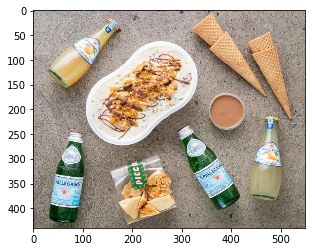

In [263]:
def plot_img(img):
    PATH='/home/ubuntu/cocacola_201904/coke_dataset/models/research/object_detection/ubereats_image/food_image/ubereats/'
    img_file= plt.imread(PATH+img) 
    plt.imshow(img_file)  

img1='bec36f5e9817a1b4027e08fed18ae4f9.jpg'
img2='3de3eebfbc3e68bb100e5beaa5e605ed.jpg'

plot_img(img1)  
# plot_img(img2) 

In [254]:
result_df.tail() 

boxes  \
995  [[0.27804732, 0.11164445, 0.52472776, 0.528079...   
996  [[0.05157963, 0.6211328, 0.40371794, 1.0], [0....   
997  [[0.12557621, 0.14154124, 0.9031523, 0.8536516...   
998  [[0.12280651, 0.06543015, 0.89426816, 0.979034...   
999  [[0.14751999, 0.20542033, 0.9186346, 0.9312793...   

                                            class_name  \
995  [2.0, 3.0, 3.0, 1.0, 2.0, 1.0, 3.0, 2.0, 1.0, ...   
996  [3.0, 3.0, 2.0, 1.0, 2.0, 1.0, 3.0, 3.0, 3.0, ...   
997  [3.0, 1.0, 2.0, 2.0, 1.0, 3.0, 1.0, 2.0, 3.0, ...   
998  [3.0, 2.0, 1.0, 3.0, 2.0, 1.0, 3.0, 3.0, 2.0, ...   
999  [3.0, 2.0, 1.0, 3.0, 1.0, 2.0, 3.0, 3.0, 2.0, ...   

                                     name  \
995  f7663bb298eb327a06ee697b00535efb.jpg   
996  37bc396d372ac8e95448b8ea28e1a893.jpg   
997  bbc23671152665c8d1c86229b682b144.jpg   
998  28a230493a0771ae80c0ca93d179e5cb.jpg   
999  b7fed74f8f98503f8d15fcb82795fcbe.jpg   

                                             pred_prob  total_detections  
995  [0.00647782, 0.004627834, 0.0035122256, 0.0033...             300.0  
996  [0.9996511, 0.9991524, 0.00030281759, 0.000260...             300.0  
997  [0.99971884, 0.00034910993, 0.00015262877, 3.4...             300.0  
998  [0.99206066, 3.7538823e-05, 2.6381038e-05, 2.1...             300.0  
999  [0.99441, 4.746879e-05, 4.515294e-05, 6.15495e...             300.0

In [228]:
result_df[result_df['name']=='bec36f5e9817a1b4027e08fed18ae4f9.jpg'] 

boxes  \
970  [[0.4555683, 0.77742684, 0.90497166, 0.9283277...   

                                            class_name  \
970  [1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 2.0, 3.0, ...   

                                     name  \
970  bec36f5e9817a1b4027e08fed18ae4f9.jpg   

                                             pred_prob  total_detections  
970  [0.9999964, 0.99997544, 0.99997544, 0.9843364,...             300.0

In [257]:
nms(result_df['boxes'][970],result_df['pred_prob'][970],0.2) 

[0, 4]

In [186]:
result_df['class_name'][970][0]

1.0

In [264]:
result_df['pred_prob'][970][0]

0.9999964

In [170]:
path = '/home/ubuntu/cocacola_201904/coke_dataset/models/research/object_detection/ubereats_image/food_image/ubereats/' 
dirs = os.listdir(path) 

image_files = list() 
images = list() 

for d in dirs[:1000]: 
    image_files.append(d)   
for image_file in image_files:  
    try:
        image = load_image_into_numpy_array(Image.open(path + image_file))
#         if image.shape[1] == 4000: #resize the images before inference 
#             continue
        images.append(image) 
    except Exception as e:
        print(str(e))  
        continue  
new_result_list = run_inference_for_multiple_images(np.array(images),image_files, g1) 
result_df = pd.DataFrame(new_result_list) 
result_df 

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 1967445448338007097), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 1806415547531169188), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17739147523760381758), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 15652398695, 15805136762040997283)]


boxes  \
0    [[0.1251028, 0.135564, 0.89659715, 1.0], [0.01...   
1    [[0.0, 0.59925455, 0.33959246, 0.8792632], [0....   
2    [[0.26603174, 0.07742255, 0.8286766, 0.8566044...   
3    [[0.0, 0.53716797, 0.30107662, 0.799219], [0.0...   
4    [[0.334608, 0.04880627, 0.74351895, 0.9231407]...   
5    [[0.0, 0.42325944, 1.0, 0.7892154], [0.0, 0.38...   
6    [[0.234671, 0.08760638, 0.54252934, 0.30357766...   
7    [[0.007598991, 0.0040356945, 0.21294731, 0.127...   
8    [[0.012387161, 0.055352252, 0.39560375, 0.2306...   
9    [[0.2338061, 0.15887281, 0.91240156, 1.0], [0....   
10   [[0.36443487, 0.31615633, 0.58765066, 0.633427...   
11   [[0.032125913, 0.34102774, 0.39121985, 0.63705...   
12   [[0.36656848, 0.16680191, 0.8412198, 0.8076139...   
13   [[0.36943197, 0.06023462, 0.8853112, 0.8359653...   
14   [[0.30867895, 0.32388085, 0.7693916, 0.6871697...   
15   [[0.21937548, 0.22872041, 0.73450583, 0.625639...   
16   [[0.037956007, 0.022360018, 0.9770919, 1.0], [...   
17   [[0.15944503, 0.19161011, 0.8460043, 0.8088554...   
18   [[0.0068749427, 0.7989257, 0.29250538, 0.99412...   
19   [[0.14483601, 0.055651948, 0.82147443, 0.95751...   
20   [[0.15191738, 0.15170136, 0.8528947, 0.9082951...   
21   [[0.07707332, 0.115630805, 0.9146165, 0.890450...   
22   [[0.14380336, 0.1810131, 0.82769024, 0.8589799...   
23   [[0.271334, 0.0834365, 0.91158324, 0.9058376],...   
24   [[0.16084304, 0.7073804, 0.44038662, 0.9873931...   
25   [[0.04353607, 0.11425664, 0.9828007, 0.9131164...   
26   [[0.20224327, 0.11173826, 0.9506803, 0.8465212...   
27   [[0.37183803, 0.43239892, 0.7249629, 0.7686237...   
28   [[0.1407703, 0.08051972, 0.82026124, 0.9847582...   
29   [[0.40986443, 0.33895278, 0.7687691, 0.6302900...   
..                                                 ...   
970  [[0.4555683, 0.77742684, 0.90497166, 0.9283277...   
971  [[0.29798016, 0.041775394, 0.87815994, 0.95971...   
972  [[0.11771645, 0.021696107, 0.9063923, 0.969802...   
973  [[0.19929402, 0.13330345, 0.84444076, 1.0], [0...   
974  [[0.15062416, 0.004767273, 0.93708205, 0.97361...   
975  [[0.016368056, 0.702503, 0.21201508, 0.8732766...   
976  [[0.007919703, 0.3497686, 0.21119106, 0.499960...   
977  [[0.38573387, 0.07299714, 0.9072611, 0.9704225...   
978  [[0.22846529, 0.073953524, 0.802049, 0.8904120...   
979  [[0.29037878, 0.26536354, 0.77165383, 0.682467...   
980  [[0.08753933, 0.6077423, 0.78218627, 0.9207777...   
981  [[0.17382179, 0.2251516, 0.82965606, 0.8634288...   
982  [[0.14132676, 0.15260023, 0.87515134, 0.829762...   
983  [[0.19389972, 0.16110948, 0.80479217, 0.884548...   
984  [[0.5803151, 0.053621005, 0.8744796, 0.3617459...   
985  [[0.46774969, 0.24541728, 0.9486957, 1.0], [0....   
986  [[0.13334297, 0.006065613, 0.8644108, 0.985078...   
987  [[0.53417706, 0.44286186, 0.76523143, 0.612664...   
988  [[0.413788, 0.11429209, 0.84576976, 0.91874516...   
989  [[0.008185844, 0.0053523104, 0.49414948, 0.220...   
990  [[0.015069084, 0.052537676, 0.4914262, 0.43248...   
991  [[0.0, 0.69090205, 0.24314983, 0.91051257], [0...   
992  [[0.08099411, 0.11181669, 0.9227778, 0.8488455...   
993  [[0.20045315, 0.21182121, 0.87086713, 0.873589...   
994  [[0.086224705, 0.20415041, 0.9750923, 0.573157...   
995  [[0.27804732, 0.11164445, 0.52472776, 0.528079...   
996  [[0.05157963, 0.6211328, 0.40371794, 1.0], [0....   
997  [[0.12557621, 0.14154124, 0.9031523, 0.8536516...   
998  [[0.12280651, 0.06543015, 0.89426816, 0.979034...   
999  [[0.14751999, 0.20542033, 0.9186346, 0.9312793...   

                                            class_name  \
0    [3.0, 2.0, 1.0, 3.0, 3.0, 1.0, 2.0, 2.0, 1.0, ...   
1    [3.0, 3.0, 3.0, 3.0, 2.0, 3.0, 1.0, 1.0, 2.0, ...   
2    [3.0, 3.0, 1.0, 2.0, 2.0, 1.0, 3.0, 3.0, 1.0, ...   
3    [3.0, 3.0, 3.0, 1.0, 2.0, 3.0, 2.0, 1.0, 2.0, ...   
4    [3.0, 1.0, 2.0, 1.0, 3.0, 3.0, 2.0, 2.0, 1.0, ...   
5    [3.0, 1.0, 3.0, 3.0, 3.0, 2.0, 1.0, 1.0, 2.0, ...   
6    [3.0, 3.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 

In [ ]:
#test with the 200 images that previously downloaded from google 
pred=pd.read_csv('pred_img.csv')
df_combined= pred.merge(true_df, on='name', how='left')
true_df=pd.read_csv('class.csv')  

In [5]:
%%time 
#use the ubereats images and generate the bottle and can result 
path = '/home/ubuntu/cocacola_201904/coke_dataset/models/research/object_detection/ubereats_image/food_image/ubereats/' 
dirs = os.listdir(path) 
image_files = list() 
images = list() 

for d in dirs[:]: 
    image_files.append(d) 
for image_file in tqdm(image_files):
    image = load_image_into_numpy_array(Image.open('/home/ubuntu/cocacola_201904/coke_dataset/models/research/object_detection/ubereats_image/food_image/ubereats/' + image_file)) 
    images.append(image) 
new_result_list = run_inference_for_multiple_images(np.array(images),image_files, g1) #the g1 is the faster rcnn graph  

result_df = pd.DataFrame(new_result_list) 
#the 2nd trained the faster rcnn model 
result_df.to_csv('pred_ubereats_fasterrcn_saturday.csv', index= False)  


[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 4697593974064314028), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_GPU:0, XLA_GPU, 17179869184, 8840470815460580325), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 5403046789968423260), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 15652398695, 10439854177986695793)]
0.68917024 3.0
0.9999981 3.0
0.7201172 3.0
0.99997973 3.0
0.18650572 3.0
0.9635703 3.0
0.999086 3.0
0.96327674 3.0
0.9999509 3.0
0.9908285 3.0
0.011831113 3.0
0.03612037 3.0
9.94099e-08 3.0
0.102659486 3.0
6.215884e-07 3.0
0.018246247 3.0
0.99649954 3.0
0.9997532 3.0
0.9866636 3.0
0.9980057 3.0
0.88118553 3.0
0.96217144 3.0
0.88032407 3.0
0.972407 3.0
0.99262697 3.0
0.8196253 3.0
0.9185858 3.0
0.008042152 3.0
0.9647523 3.0
0.8403492 3.0
0.99999654 3.0
0.9999987 3.0
0.91083664 3.0
0.13915563 3.0
0.9468377 3.0
0.96804273 3.0
5.5414857e-05 3.0
0.99828124 3.0
0.999

0.9999354 3.0
0.9998518 3.0
0.14821528 3.0
0.99997425 3.0
0.00057113415 3.0
0.48465404 3.0
0.9021112 3.0
0.6509969 3.0
0.031464137 3.0
0.6515361 3.0
0.47005934 3.0
0.98137534 3.0
0.90716803 3.0
0.9994573 3.0
0.99917406 3.0
0.0013068832 3.0
0.99998415 3.0
0.68448704 3.0
0.99740773 3.0
0.004598671 3.0
0.001100918 3.0
0.994212 3.0
0.99865484 3.0
0.9919201 3.0
0.73940724 3.0
0.999225 3.0
0.99635005 3.0
0.99987125 3.0
6.506752e-07 3.0
0.97992283 3.0
0.9950434 3.0
0.64069587 3.0
0.92337936 3.0
0.952292 3.0
0.99796116 3.0
0.9996062 3.0
0.98136157 3.0
0.92335224 3.0
0.92093277 3.0
0.9970018 3.0
0.00072329334 3.0
0.99999225 3.0
0.99859005 3.0
0.99948645 3.0
0.99363756 3.0
0.9863811 3.0
0.9999875 3.0
0.3104245 3.0
9.645611e-10 3.0
0.34330758 3.0
2.5605164e-06 3.0
0.6811615 3.0
0.87999123 1.0
0.10086479 3.0
0.17127815 3.0
0.98482937 3.0
0.99918574 3.0
0.9819775 3.0
0.8067555 3.0
0.9998093 3.0
0.9991543 3.0
0.9999943 3.0
0.0011149438 2.0
0.94907004 2.0
0.81992054 3.0
0.999998 1.0
0.91197383 3.0
0.

0.7246531 3.0
0.98301363 3.0
0.0015716613 3.0
0.7512113 3.0
0.0035080656 3.0
0.9604595 3.0
0.9529476 3.0
0.9348072 3.0
0.99999464 3.0
0.9868912 3.0
0.0037743836 3.0
0.99971205 2.0
2.3044706e-05 3.0
0.99997234 3.0
0.7526584 3.0
0.8687316 3.0
0.17205508 3.0
0.87075084 3.0
0.29384303 3.0
0.9999881 3.0
0.99906176 3.0
0.8912187 3.0
0.9998041 1.0
0.79276395 3.0
0.58670163 3.0
0.99359 3.0
0.99995255 2.0
0.0022638838 3.0
0.9966066 3.0
0.9982126 3.0
0.6282603 3.0
0.7416342 3.0
0.99946576 3.0
0.99582905 2.0
0.99518085 3.0
0.26949045 3.0
0.9296143 3.0
0.790219 3.0
0.40692866 3.0
0.9925327 3.0
0.9988104 3.0
0.0012709635 3.0
0.97652596 3.0
0.853144 3.0
0.0011914656 3.0
0.6536982 3.0
0.99951756 3.0
0.99998724 1.0
0.97969764 3.0
0.9966164 3.0
0.8881854 3.0
0.93677986 3.0
0.9620784 3.0
0.9941677 3.0
0.9447218 3.0
0.4715302 3.0
0.91627306 3.0
0.9958587 3.0
0.9773538 3.0
0.7431673 3.0
0.99969935 3.0
0.09492921 3.0
0.7902986 3.0
0.99975044 3.0
0.1416359 3.0
0.9293537 3.0
0.9914444 3.0
0.63475996 3.0
0.77

0.9936114 3.0
0.85316306 3.0
0.99703264 3.0
1.5109837e-06 3.0
0.9999975 3.0
0.9986451 3.0
0.5489407 3.0
0.9998534 3.0
0.9997316 2.0
0.93553853 2.0
0.99996006 3.0
0.9717102 3.0
0.2288502 3.0
0.9999968 3.0
0.003106608 3.0
0.9995365 3.0
0.99165714 3.0
0.99729294 3.0
0.99411136 2.0
0.00042628453 3.0
0.99382293 3.0
0.38614947 3.0
0.0025294428 3.0
0.9901793 3.0
0.9999168 3.0
0.000928512 3.0
0.34760243 3.0
0.79241955 3.0
0.9942894 3.0
3.5213366e-06 3.0
0.99559635 3.0
0.9936108 3.0
0.95056015 3.0
0.99999785 3.0
0.9903842 2.0
0.99998724 3.0
0.95499223 3.0
0.46383035 3.0
5.019681e-05 3.0
0.48495105 3.0
0.00024189813 3.0
0.99950254 3.0
0.99987125 3.0
0.9999746 3.0
0.99997103 3.0
0.98387295 3.0
0.3507837 3.0
0.9792044 3.0
0.9934022 3.0
0.9246065 3.0
0.99989533 3.0
0.9937139 3.0
0.0017485259 3.0
0.6000295 3.0
0.9569821 2.0
0.9599542 3.0
4.2747237e-07 3.0
0.98549485 3.0
0.9206126 3.0
0.99904484 1.0
0.9984944 3.0
0.3449588 3.0
0.0024743902 3.0
4.634218e-05 3.0
0.87167585 3.0
0.9736024 3.0
0.45141193 

8.644571e-10 3.0
0.7819507 3.0
0.30139565 3.0
0.99997973 3.0
0.00010721715 3.0
0.99999475 3.0
0.96307194 3.0
0.9907767 3.0
0.8725838 3.0
0.9907776 3.0
5.3347958e-05 3.0
0.9930147 3.0
0.99915254 3.0
0.99917775 3.0
0.025421897 3.0
0.97412336 3.0
0.3673395 3.0
0.337584 3.0
0.9910539 3.0
0.93207544 3.0
0.29057318 3.0
0.99998045 2.0
0.0013846033 2.0
0.52325106 3.0
0.95293385 3.0
0.8629854 3.0
0.027394721 3.0
0.9999968 1.0
0.9999219 3.0
2.1618248e-06 3.0
0.9996356 3.0
0.9988927 3.0
0.9960861 3.0
0.91368383 3.0
0.19662115 3.0
0.71628016 3.0
0.001828171 3.0
0.9998647 3.0
0.41113806 3.0
0.010567472 3.0
0.03232552 3.0
0.14584145 3.0
0.56758654 3.0
0.045046207 3.0
0.99999154 3.0
0.9999964 3.0
0.73028636 3.0
0.9709882 3.0
0.9940169 3.0
0.8915912 3.0
0.99944454 3.0
0.5572864 3.0
0.7974419 3.0
0.9999794 3.0
0.06438984 3.0
0.002218532 3.0
2.0574228e-06 3.0
0.042884964 3.0
0.88573104 3.0
0.9515377 3.0
0.02351618 3.0
0.9994185 3.0
1.22747315e-08 3.0
0.9448782 3.0
0.036691748 3.0
0.97418755 3.0
0.458531

0.14881533 3.0
0.99946743 3.0
0.99797267 3.0
0.366133 3.0
0.31609756 3.0
0.9977361 3.0
0.0005251173 3.0
4.502294e-05 3.0
0.0039865 3.0
0.99922 3.0
0.92068946 3.0
0.01081076 3.0
0.89186686 3.0
0.9999914 3.0
0.96911377 3.0
0.011845212 3.0
0.71252847 3.0
0.99959177 3.0
0.03152204 3.0
0.9198485 3.0
0.9999987 3.0
0.07718224 3.0
0.92152715 3.0
0.9986137 3.0
0.9972356 3.0
0.0003834181 3.0
0.00012723383 3.0
0.99998486 3.0
0.0075098923 3.0
0.71881646 3.0
0.9956227 3.0
0.9732589 3.0
0.9996921 2.0
0.13071394 3.0
0.9999641 3.0
0.13663024 3.0
0.99848205 3.0
0.99093074 3.0
0.84003484 3.0
0.008841719 3.0
2.3875864e-05 3.0
0.0006366117 3.0
0.99701995 3.0
0.958767 2.0
0.8756859 3.0
0.0104883425 3.0
0.76552135 2.0
0.99982685 3.0
0.99980706 3.0
0.9968934 3.0
0.938652 3.0
0.0025004472 3.0
0.3577713 3.0
0.99620724 3.0
0.03632879 3.0
0.9999814 3.0
0.9676449 3.0
0.9765927 3.0
0.0022568163 3.0
0.9999591 3.0
0.07604478 3.0
0.781059 3.0
0.5787577 3.0
0.99390525 3.0
0.004157522 3.0
0.8610622 3.0
0.9999498 2.0
0.

0.9999945 1.0
0.6310087 3.0
0.99613756 3.0
0.8219836 3.0
0.8526564 3.0
0.6635852 3.0
0.99765575 3.0
0.05579273 3.0
0.6667999 3.0
0.98559153 3.0
0.014404881 3.0
0.91612875 3.0
0.7535432 3.0
0.99425054 3.0
0.9986779 3.0
0.23071574 3.0
0.35316485 3.0
0.0018329135 3.0
0.00037142393 3.0
0.99790823 3.0
0.97250825 2.0
0.9999708 3.0
0.99999857 3.0
0.0047449316 3.0
0.91062534 3.0
0.80143046 2.0
0.95074904 3.0
0.7137494 3.0
0.11467485 3.0
0.99862313 2.0
0.19187587 3.0
0.9999951 3.0
0.999283 3.0
0.9994261 3.0
0.6172287 3.0
0.9965612 3.0
2.6037233e-07 3.0
0.95269996 3.0
0.48111713 3.0
0.99962497 3.0
0.9999956 3.0
0.9999951 2.0
0.9981171 3.0
2.343253e-10 3.0
0.3545208 3.0
0.021149697 3.0
6.943947e-05 3.0
0.0010494291 3.0
0.6092789 3.0
0.9994972 3.0
0.9999654 3.0
0.04253263 3.0
0.035510242 3.0
0.8704211 3.0
0.9918345 3.0
0.99999976 3.0
1.12197345e-08 3.0
0.9996687 3.0
0.9949787 3.0
0.0010956875 3.0
0.67752844 3.0
0.9995271 3.0
0.99991095 3.0
0.99874914 3.0
0.98877233 3.0
0.9995022 3.0
0.9866301 3.0


0.99998283 3.0
0.9999974 3.0
0.8927826 3.0
0.833514 3.0
0.006973221 3.0
0.99225557 3.0
0.12680347 3.0
0.99999106 3.0
0.999803 3.0
0.5796533 3.0
0.8978801 3.0
0.0021660146 3.0
0.96040684 3.0
0.6213271 3.0
0.9809177 3.0
0.9020656 3.0
0.9956727 3.0
0.9210605 3.0
0.006424101 3.0
0.8761529 3.0
0.99412113 3.0
0.99999356 3.0
0.00020834015 3.0
0.99608433 3.0
0.9994091 1.0
0.9299007 2.0
0.6327242 3.0
0.85043436 3.0
0.9927309 3.0
1.4473939e-06 3.0
0.9992674 3.0
0.02849659 3.0
0.9999534 3.0
0.8368241 3.0
0.013627838 3.0
0.99997747 3.0
0.2820731 3.0
0.88191056 3.0
0.99981934 3.0
0.9705824 3.0
0.9999975 3.0
0.9937364 3.0
0.99999535 3.0
0.93313104 3.0
0.9850767 3.0
0.96846884 3.0
0.075626306 3.0
0.9999999 1.0
0.76494676 3.0
0.9237797 3.0
0.88301575 1.0
0.81427014 2.0
0.9474937 3.0
0.88037264 3.0
0.935024 1.0
0.9680866 3.0
0.17236428 2.0
0.24471918 3.0
0.9662973 3.0
0.9689762 3.0
0.9259997 3.0
0.0016632216 3.0
0.9999976 1.0
0.0015529935 3.0
0.9998411 3.0
0.9979201 3.0
0.9999461 3.0
0.9998927 3.0
0.07

0.09701942 3.0
0.99558455 3.0
0.9612735 3.0
0.99989617 1.0
5.6883937e-06 3.0
0.000114199145 3.0
0.9999989 3.0
0.9999989 1.0
0.9999771 3.0
0.918248 3.0
7.48794e-05 3.0
0.99982125 3.0
0.99998593 3.0
0.91486436 3.0
0.7890598 3.0
0.9996113 3.0
3.6232294e-07 3.0
0.9889264 3.0
0.29632056 3.0
0.9669676 3.0
0.11745745 3.0
0.9999708 3.0
0.89929676 3.0
0.9516937 3.0
0.5542769 3.0
0.99825746 3.0
0.09184622 3.0
0.9992011 3.0
0.9976822 3.0
0.99396545 3.0
0.4834229 3.0
0.99976903 2.0
0.8746161 3.0
0.0032206904 3.0
0.020193286 3.0
0.9999236 3.0
0.69868606 3.0
0.044851687 3.0
0.9999962 3.0
0.040664904 2.0
0.9987213 3.0
0.9995721 3.0
0.9976203 3.0
0.998429 3.0
0.74818355 3.0
0.9999486 3.0
0.052051485 3.0
0.0066381954 3.0
0.17164275 3.0
0.95039916 2.0
0.9544135 3.0
0.9961976 3.0
0.9825084 3.0
2.4867639e-05 3.0
0.14907798 3.0
0.77486134 3.0
0.014163746 3.0
0.99235183 3.0
0.9765013 3.0
0.9597194 3.0
0.9017469 3.0
0.6336676 3.0
0.9999212 3.0
0.6807707 3.0
0.5301942 3.0
0.99840754 3.0
0.99884075 3.0
0.00911

0.99997425 3.0
0.87981576 3.0
0.012704692 3.0
0.48171395 3.0
0.48385707 3.0
0.9983438 3.0
0.003146018 3.0
0.9999869 3.0
0.00040959544 3.0
0.9971404 3.0
0.30864844 3.0
0.04808251 2.0
0.99713767 3.0
0.99999 3.0
0.98506826 3.0
0.9999292 3.0
0.69034255 3.0
0.26439083 3.0
0.9999968 3.0
3.7796904e-06 3.0
0.39026794 3.0
0.999052 3.0
0.9765405 3.0
0.20440088 3.0
0.8502758 3.0
6.0576053e-06 3.0
0.911753 3.0
0.5022538 3.0
0.99998915 3.0
0.52604294 3.0
0.9770643 3.0
0.8248147 3.0
0.999951 3.0
0.9970196 3.0
0.9166503 3.0
0.88796055 3.0
0.9977679 3.0
0.9768593 3.0
0.8703634 3.0
0.1614442 3.0
0.99944085 3.0
0.90207964 3.0
0.9753304 3.0
0.96612555 3.0
0.96113473 3.0
0.9578552 3.0
0.9827434 3.0
0.97561306 3.0
0.079683036 3.0
0.034757994 3.0
0.99999726 3.0
0.27148116 3.0
0.67191505 3.0
0.0005855704 3.0
0.9999949 3.0
0.999361 3.0
0.96787506 2.0
0.5003163 3.0
0.000105367275 2.0
0.030657882 3.0
1.0456661e-09 3.0
0.98321277 2.0
0.99581957 3.0
0.08220154 3.0
0.99841845 3.0
0.99999857 3.0
0.8312559 3.0
0.000

0.9083046 2.0
0.6528765 3.0
0.9810204 3.0
0.44504237 3.0
0.7418596 3.0
0.9999919 3.0
0.9462392 3.0
0.9638107 3.0
0.59554935 3.0
0.9931339 3.0
0.9924563 3.0
0.050250154 3.0
0.9952976 3.0
0.9996327 3.0
0.99852103 3.0
0.99859494 3.0
0.5274399 3.0
0.99045765 3.0
0.35385415 3.0
0.99841666 3.0
0.9910665 3.0
0.1210364 3.0
0.22963978 3.0
0.9999964 3.0
0.9385188 3.0
0.99992037 1.0
0.9999783 3.0
0.9996339 3.0
0.99985397 2.0
0.9056743 3.0
0.9999536 3.0
0.9873104 3.0
0.9937848 3.0
0.01922662 3.0
0.55413336 3.0
0.0077048517 3.0
0.09449813 3.0
0.9999027 3.0
0.03627055 3.0
0.99730194 3.0
0.15044758 3.0
0.32866007 3.0
0.9984061 3.0
0.9853365 3.0
0.99575245 2.0
0.9886696 3.0
0.9141481 3.0
0.9811091 3.0
0.9382393 3.0
0.99988914 3.0
0.70167774 3.0
0.9999913 2.0
0.99673367 3.0
0.8436379 3.0
6.6328822e-09 3.0
0.99999785 1.0
0.020704487 3.0
0.99554515 3.0
0.14972629 3.0
0.9999039 3.0
0.56979185 3.0
0.8901804 3.0
0.87053406 3.0
0.99704117 3.0
0.98945355 2.0
0.99998343 3.0
3.141499e-05 3.0
0.9952407 3.0
0.011

0.81260675 3.0
0.8714432 3.0
0.8146184 3.0
0.30218256 3.0
0.18244234 3.0
0.9998548 3.0
0.9022055 3.0
0.9814866 3.0
0.97096777 3.0
0.9998926 3.0
0.884354 3.0
0.99999857 3.0
0.9948538 3.0
0.98083705 3.0
0.99999297 3.0
0.00028228463 3.0
0.9681525 3.0
0.44624785 3.0
0.18606564 3.0
0.99901295 1.0
0.6546523 3.0
0.9999819 2.0
0.9944977 3.0
0.96687526 3.0
0.9999136 3.0
0.07802027 3.0
0.99445665 3.0
0.018945284 3.0
0.0046816627 3.0
0.9963671 3.0
0.94777846 1.0
0.000310363 3.0
0.99969935 1.0
0.78829587 3.0
0.113345444 3.0
0.0011036682 3.0
0.791046 3.0
0.96102536 3.0
0.081241235 3.0
0.029110271 3.0
0.42207143 3.0
0.34447348 3.0
0.98137087 3.0
0.6446654 3.0
0.972559 3.0
0.9778501 3.0
0.43469888 3.0
0.9995797 3.0
8.7037015e-06 3.0
0.9462879 3.0
0.013790746 3.0
0.9999809 3.0
0.98345596 3.0
0.9999821 3.0
0.9895579 3.0
0.9997919 1.0
0.0004996618 3.0
0.9999373 3.0
0.99958533 3.0
0.99976856 3.0
0.39830238 3.0
0.002682426 3.0
0.9867339 3.0
0.8830975 3.0
0.9871761 3.0
0.97788984 3.0
0.98772067 3.0
0.74304

0.21701935 3.0
0.7148294 3.0
0.21603917 3.0
0.9932334 1.0
0.9999968 3.0
0.65848917 3.0
0.9981345 3.0
0.91692626 3.0
0.9833999 3.0
0.9999387 3.0
0.9999856 1.0
0.9975031 2.0
0.9508443 1.0
0.9934094 3.0
0.0012719235 3.0
0.99985695 3.0
0.012773445 3.0
5.2025065e-05 3.0
9.2903365e-06 3.0
0.6001616 3.0
0.46859622 3.0
0.76530194 3.0
0.9848029 3.0
0.99982303 3.0
4.7661338e-06 3.0
0.23511696 3.0
0.997874 3.0
0.7412155 3.0
0.9999958 3.0
0.36822784 3.0
0.113906 3.0
0.9998512 3.0
0.9476536 3.0
0.999086 3.0
0.9999988 2.0
0.7511062 3.0
0.99789894 3.0
0.4528638 3.0
0.9278623 3.0
0.8645421 3.0
0.99937916 3.0
0.12896068 3.0
0.9998851 3.0
0.99793833 3.0
0.99275136 3.0
0.26174816 3.0
0.9482193 3.0
0.99800545 3.0
0.99993 3.0
0.9781737 2.0
0.991546 3.0
0.8274111 3.0
0.66362756 3.0
0.97335106 3.0
0.98775744 3.0
0.0001600205 3.0
0.9929751 3.0
0.9999975 3.0
6.2216272e-06 3.0
0.99999523 3.0
0.9529206 3.0
0.9999962 3.0
0.99994814 1.0
0.95901424 3.0
0.9999188 3.0
0.6601949 3.0
0.15420972 3.0
0.79095465 3.0
0.914

0.006024508 3.0
4.863286e-06 3.0
0.67836326 3.0
0.803664 3.0
0.39905283 3.0
0.005051067 3.0
0.999814 3.0
0.9728478 2.0
0.92945784 3.0
0.99988747 3.0
0.33506694 3.0
0.19901597 3.0
0.08654524 3.0
0.0026071882 3.0
0.99093187 3.0
0.13892102 3.0
0.9999912 3.0
0.9995666 3.0
0.030281458 3.0
0.999424 3.0
0.6831966 1.0
0.9998553 3.0
0.9801979 1.0
0.9986665 3.0
0.9359097 3.0
0.97979593 3.0
0.9943727 3.0
0.97743523 3.0
0.53867114 3.0
0.0026210176 3.0
0.75003064 3.0
0.9924171 3.0
0.6879333 3.0
0.2685373 3.0
0.13417488 3.0
0.99628 3.0
1.6712069e-06 3.0
0.004520172 3.0
0.042616483 3.0
0.012121648 3.0
0.99999666 1.0
0.9990484 3.0
0.94468224 2.0
0.9418642 2.0
0.9999995 1.0
0.07669443 3.0
0.9929906 3.0
0.9984086 3.0
0.8553943 3.0
0.99999034 3.0
0.18467467 3.0
0.7453052 3.0
0.612895 3.0
0.99749076 3.0
0.7391007 3.0
0.73709047 3.0
0.99986994 3.0
0.999992 1.0
0.9988973 3.0
0.9600355 3.0
0.999705 3.0
0.013364938 3.0
0.9999988 3.0
0.9576839 3.0
0.030626124 3.0
0.78000027 3.0
0.9999752 3.0
0.9999906 3.0
0.99

0.9999176 3.0
0.4407927 3.0
0.94863385 3.0
0.70622736 3.0
0.9954853 2.0
0.9066821 3.0
0.9915658 3.0
0.9998944 1.0
0.9996829 3.0
0.99942386 1.0
0.99999166 3.0
0.81732106 3.0
0.9968479 3.0
7.669181e-05 3.0
0.9977188 3.0
0.67715967 3.0
0.5725157 3.0
0.997715 3.0
7.468114e-07 3.0
0.9996829 3.0
0.99971 3.0
0.046606075 3.0
0.9836479 3.0
0.80778646 3.0
0.24313717 3.0
0.648372 3.0
0.9999666 3.0
0.030528106 3.0
0.9517331 3.0
0.999874 3.0
0.9998373 3.0
0.0086813355 3.0
0.15931892 3.0
0.0009413182 3.0
0.8580463 3.0
0.99726677 3.0
0.0057271817 3.0
0.99696237 3.0
0.9999958 3.0
7.505518e-05 3.0
0.9998692 3.0
0.17546119 3.0
0.81385946 3.0
0.9998215 3.0
0.082491435 3.0
0.93572414 3.0
0.16643207 3.0
0.1660662 3.0
0.99995506 3.0
0.99981767 3.0
6.1801586e-08 3.0
0.15012632 3.0
0.038612995 3.0
0.98823893 3.0
0.9998246 3.0
2.6827909e-09 3.0
0.2253648 3.0
0.1150598 3.0
0.061353143 3.0
0.006433867 3.0
0.00030770223 3.0
0.999843 3.0
6.999089e-11 3.0
0.07423238 3.0
0.9951918 3.0
0.9999355 3.0
0.034592643 3.0
0

1.1588009e-09 3.0
0.9999323 3.0
0.40016925 3.0
0.9999206 3.0
0.9867128 3.0
0.27773112 3.0
0.19098201 3.0
0.99812526 3.0
0.024717864 3.0
0.9999933 3.0
0.0031276986 3.0
0.99923 3.0
0.66639066 3.0
0.048789706 3.0
0.94601464 3.0
0.013184538 3.0
0.9956163 3.0
0.21961871 3.0
0.9738758 3.0
0.99591225 3.0
0.0007458768 3.0
0.04880589 3.0
0.98731613 3.0
0.0076383078 3.0
0.22618884 3.0
0.9990557 3.0
0.9399451 3.0
0.00013255222 3.0
0.85725814 3.0
0.6485149 3.0
0.50496984 3.0
0.8973199 3.0
0.9999933 1.0
0.1855149 3.0
0.96227443 3.0
0.99237776 3.0
0.9999231 3.0
0.9985764 3.0
0.8270214 3.0
0.99869883 3.0
0.9748762 3.0
6.136032e-06 3.0
0.0040622056 3.0
0.00010218818 3.0
0.003204871 3.0
0.44265175 3.0
0.9327676 3.0
0.9727376 3.0
0.7661291 3.0
0.019029133 3.0
0.0010514975 3.0
0.99324715 3.0
0.008930122 3.0
0.0720324 3.0
0.999987 3.0
0.9999678 3.0
0.9987679 3.0
0.00010687277 3.0
0.0012707118 3.0
0.9986008 3.0
0.86432785 3.0
0.9993591 3.0
0.9996604 3.0
0.99841607 3.0
0.9999938 3.0
0.7690443 3.0
0.9999399 

0.4009272 3.0
0.9999989 3.0
0.0040742783 3.0
0.99978906 3.0
0.9990466 3.0
0.97745174 3.0
0.74849796 3.0
0.99743026 3.0
0.99994516 3.0
0.9937761 3.0
0.82694525 3.0
0.99850804 3.0
0.042383198 1.0
0.042880468 3.0
0.68496805 3.0
0.9999968 3.0
0.1671272 3.0
0.19910358 3.0
0.00055989594 3.0
0.26151812 3.0
0.9994803 3.0
0.9541798 3.0
0.037918217 1.0
0.087989636 3.0
0.98789144 3.0
0.19483224 3.0
0.99993503 3.0
0.98872524 3.0
0.9999598 3.0
0.0072509446 3.0
0.9999689 3.0
0.99845695 2.0
0.99950874 3.0
0.9800751 3.0
0.6305371 3.0
0.9973865 3.0
0.999959 3.0
0.32994613 3.0
0.99500895 3.0
0.9995097 3.0
0.34405455 3.0
0.86402583 3.0
0.87997806 2.0
0.97635275 3.0
0.013936226 3.0
0.99983156 3.0
0.97962534 3.0
0.0002625356 3.0
0.0010696664 3.0
0.8195014 3.0
0.99138004 3.0
0.1816735 3.0
0.9717215 3.0
0.34966916 3.0
0.9999907 3.0
0.9664764 2.0
0.99928206 3.0
0.938323 3.0
0.8913057 3.0
0.91480815 3.0
0.8491169 3.0
0.9956956 3.0
0.917473 3.0
0.2883916 3.0
0.6433034 3.0
0.9636772 3.0
0.9990565 3.0
0.8383961 3

0.9048251 3.0
0.9993728 3.0
0.9998853 3.0
0.97959936 3.0
0.9747522 3.0
0.041672323 3.0
0.99417615 3.0
0.989036 3.0
0.0009547843 3.0
0.002667143 3.0
0.9410174 3.0
0.9999944 3.0
0.9864884 2.0
0.8393607 3.0
0.99977773 3.0
0.6785209 3.0
0.99771935 3.0
0.0011201537 3.0
0.0034553702 3.0
0.2618655 3.0
0.02644356 3.0
0.9999521 3.0
3.566253e-05 3.0
0.9103751 3.0
0.9234818 3.0
0.36172184 3.0
0.0010153247 2.0
0.9997491 3.0
1.8885463e-05 3.0
0.021174362 3.0
0.8950599 3.0
0.99982893 3.0
0.7039043 3.0
0.00088034355 3.0
0.9999956 3.0
0.999972 3.0
0.92798287 3.0
0.9997471 3.0
0.18022045 3.0
0.9989096 3.0
0.22908193 3.0
0.9816316 3.0
0.9898295 3.0
0.0034334378 3.0
4.2332624e-05 3.0
0.9486004 3.0
0.9063968 3.0
0.0004608416 3.0
0.57096624 3.0
0.8190011 3.0
0.999466 3.0
0.000107965076 3.0
0.99071056 3.0
0.99321085 2.0
0.99971956 3.0
0.9020514 3.0
0.9689752 3.0
0.9679167 3.0
0.99966776 3.0
0.9999596 3.0
0.33660477 2.0
0.9999974 3.0
0.4017044 3.0
0.3671022 3.0
0.82466483 3.0
9.9733334e-08 3.0
0.9999913 3.0


1.9072588e-05 3.0
0.9465944 2.0
0.9948053 3.0
0.2683988 3.0
0.0011043244 3.0
0.9999703 3.0
0.90776664 3.0
0.9953934 3.0
0.46056393 3.0
0.9967803 3.0
0.9982003 3.0
0.9999938 3.0
0.00053130696 3.0
0.69825107 3.0
0.9058693 3.0
0.9995098 3.0
0.60292596 3.0
0.0034704015 3.0
0.91348714 3.0
0.9999956 3.0
0.97200364 3.0
0.9941334 3.0
0.025047684 3.0
0.9999937 3.0
0.25121963 3.0
0.16834523 3.0
0.14556885 3.0
0.00015108113 3.0
0.97776675 3.0
0.07997309 3.0
0.9984849 3.0
0.00032868542 3.0
0.007785961 3.0
0.17710382 3.0
0.6494476 3.0
0.99998057 3.0
0.9999908 3.0
0.96224713 3.0
0.83544207 2.0
0.009087997 3.0
0.040603913 3.0
0.98150384 3.0
0.0006034777 3.0
0.9998541 3.0
0.9994893 2.0
0.9517508 3.0
0.99605966 3.0
0.9932546 3.0
0.9962484 3.0
0.9817884 3.0
0.003008899 3.0
0.28895703 3.0
0.10158643 3.0
0.9984143 3.0
5.6143946e-08 3.0
0.086191565 3.0
0.9765712 3.0
0.98643327 3.0
0.9999119 3.0
0.9920781 3.0
0.9999988 3.0
0.09529803 3.0
0.009818997 3.0
0.999974 3.0
0.9999988 3.0
0.9999825 3.0
0.9525997 3.0

0.9999517 3.0
0.9906488 3.0
0.9827685 3.0
0.99995875 3.0
0.9997198 3.0
0.8780794 3.0
0.29409534 3.0
0.9996055 3.0
0.02208238 3.0
0.99192554 2.0
8.9098576e-05 3.0
0.47510302 3.0
0.7567191 3.0
0.00030337932 2.0
0.9817028 3.0
0.11474834 3.0
0.9792753 3.0
0.99996185 3.0
0.9894583 3.0
0.0017444161 3.0
0.027582947 3.0
0.99959975 3.0
0.86215156 3.0
0.99462116 3.0
0.045998674 3.0
0.99655956 3.0
0.99863416 3.0
0.99999607 3.0
0.7986449 3.0
0.999814 3.0
0.9965508 3.0
0.9501221 3.0
0.961501 3.0
0.9974745 3.0
0.998027 3.0
0.23948304 3.0
0.013350142 2.0
0.32498008 2.0
0.51789606 3.0
0.9479747 3.0
0.021562222 3.0
0.981898 3.0
0.559123 3.0
0.0114887925 3.0
0.00079290534 3.0
0.36742294 3.0
0.99999595 3.0
0.9998004 3.0
0.979836 1.0
0.8145235 3.0
0.99481994 3.0
0.98490566 3.0
0.077544294 3.0
0.0016617231 3.0
0.14547522 3.0
0.9945496 3.0
0.4921264 3.0
0.9950126 3.0
0.9998017 3.0
0.9982835 3.0
0.002634828 3.0
0.6907932 3.0
0.054207716 3.0
0.93995684 3.0
0.99999666 3.0
0.99997854 3.0
0.21867783 3.0
0.060606

0.9999682 3.0
0.15366398 3.0
0.9999496 3.0
0.99948275 3.0
0.769134 3.0
0.99463224 2.0
0.7228144 3.0
0.7121541 3.0
0.9938076 3.0
0.99991286 3.0
0.9989875 3.0
0.9982383 3.0
0.0057549807 3.0
0.9998317 1.0
0.031656604 3.0
0.999511 3.0
0.029546477 3.0
0.9974899 3.0
0.995301 3.0
0.001363631 3.0
0.0022579683 3.0
0.11276611 3.0
0.9312278 3.0
0.8925391 3.0
0.99999964 1.0
0.9998877 2.0
0.9379418 3.0
2.9165138e-05 3.0
0.6917414 3.0
3.0481837e-05 3.0
3.600439e-05 3.0
0.31764895 3.0
0.99994576 3.0
0.9999337 3.0
0.99475765 3.0
0.22294395 3.0
0.97117573 3.0
0.99869776 3.0
0.0033729547 3.0
0.90907717 3.0
0.99999464 3.0
0.41708383 3.0
0.99999166 3.0
0.9938251 3.0
6.830186e-07 3.0
0.99984646 2.0
0.96760637 3.0
0.0001708073 3.0
0.0609683 3.0
0.9865589 3.0
0.0060350215 3.0
0.81970894 3.0
0.010496148 3.0
0.9999461 3.0
0.99970466 3.0
0.96389616 3.0
0.2764347 3.0
0.9967636 3.0
0.0879582 3.0
0.9597248 3.0
0.9997316 3.0
0.0016510336 3.0
0.0040098093 3.0
0.9998264 3.0
0.99996173 3.0
0.0972376 3.0
0.9996455 3.0


0.0470798 3.0
0.99997306 2.0
0.99870944 3.0
0.99937683 3.0
0.98061234 3.0
0.98558503 2.0
0.9999851 3.0
0.9994485 3.0
0.9998766 3.0
0.9990503 3.0
0.6189082 3.0
0.7340815 3.0
0.043974258 3.0
0.99999225 3.0
6.465218e-05 3.0
0.18603064 3.0
0.990824 3.0
0.0140710715 3.0
0.99998796 1.0
0.08958922 3.0
0.011651428 3.0
0.98712885 3.0
0.0183605 3.0
0.98979026 2.0
0.04657794 3.0
0.9999956 3.0
0.46514958 3.0
0.99446857 3.0
0.9999753 3.0
0.0006204905 3.0
0.98437876 3.0
0.98467296 3.0
0.9999958 2.0
0.00066218537 3.0
0.9998728 3.0
0.97963035 3.0
0.016806798 3.0
0.9994475 3.0
5.3697563e-06 3.0
0.96364415 3.0
0.871752 3.0
0.9999995 3.0
0.17694673 3.0
0.9994448 3.0
0.9845738 3.0
8.863421e-06 3.0
0.9997459 3.0
0.99989665 3.0
0.9999865 3.0
0.09788841 3.0
0.99966466 3.0
0.91225886 3.0
0.99587905 3.0
0.99994516 3.0
0.9998553 3.0
0.9999981 1.0
0.9958538 3.0
0.9981779 1.0
0.01503974 3.0
0.10039433 3.0
0.995924 3.0
0.98408395 3.0
0.8146528 3.0
0.67564017 3.0
0.05629785 3.0
0.9999956 3.0
0.9882102 3.0
0.0009853

0.99237895 3.0
0.99069655 3.0
0.9993962 3.0
0.99278545 3.0
0.99998224 3.0
0.9995271 3.0
0.4875586 3.0
0.9989171 3.0
0.99918085 3.0
0.99998343 3.0
0.26825783 3.0
0.9955433 3.0
0.9509648 3.0
0.9989189 3.0
0.90259784 3.0
0.5398083 3.0
2.3919104e-09 3.0
0.9998617 3.0
0.980316 3.0
8.3042477e-07 3.0
0.06841631 3.0
0.00032424138 3.0
0.028474353 3.0
0.9991123 3.0
0.9976578 3.0
0.999877 1.0
0.9992021 3.0
0.9916991 3.0
0.0073388005 3.0
0.9233682 3.0
0.0038774805 3.0
0.90336555 3.0
0.02062614 3.0
3.5717852e-07 3.0
0.47282073 2.0
0.9867338 3.0
0.8384809 3.0
0.677057 3.0
0.62503767 3.0
0.98841 3.0
0.54507476 3.0
0.9999975 3.0
2.8834697e-07 3.0
0.9978637 3.0
0.9822922 3.0
0.8660931 3.0
0.0083543835 3.0
0.90632313 3.0
0.49811184 3.0
0.95221084 3.0
0.9950655 3.0
0.9961569 3.0
0.999915 3.0
0.99999976 1.0
0.99697506 3.0
0.99998987 3.0
0.27036527 3.0
0.9976392 3.0
0.93017024 3.0
0.9992378 3.0
0.22248612 3.0
0.95802397 2.0
0.23576799 3.0
4.7392928e-06 3.0
0.98364234 3.0
0.9929542 3.0
0.89084387 3.0
0.9935

0.18559355 3.0
0.006033012 3.0
0.987483 3.0
0.92387545 3.0
0.007852295 3.0
0.058808718 3.0
0.99800247 3.0
0.9823856 3.0
0.0025643776 3.0
0.9970072 3.0
0.16961117 3.0
0.99913436 3.0
4.658974e-06 3.0
0.47075263 3.0
0.99953854 3.0
0.99994016 3.0
0.95928514 2.0
0.99908006 3.0
0.9998561 3.0
0.9978446 2.0
0.9052303 3.0
0.003946881 3.0
0.0019097644 3.0
0.9906137 3.0
0.69908035 3.0
0.98667824 3.0
0.9704187 3.0
0.99824464 3.0
0.0006623152 3.0
0.9995653 3.0
0.99931514 3.0
0.8366043 3.0
0.9081553 3.0
0.9080481 3.0
0.8435906 3.0
0.15884814 2.0
0.99908125 3.0
0.09150317 3.0
0.991381 3.0
0.6574781 3.0
0.99561214 3.0
0.64891124 3.0
0.9937389 3.0
0.015378997 3.0
0.8217766 3.0
0.00033179758 3.0
0.00035531944 3.0
0.9999976 3.0
0.9557919 3.0
0.9971232 3.0
0.49509266 3.0
0.010574876 3.0
0.05541667 3.0
0.99999523 3.0
0.90179265 3.0
0.20385547 3.0
0.99998176 3.0
0.02290614 3.0
0.0027063645 3.0
0.99982446 3.0
0.9596697 2.0
0.55201185 3.0
0.9989151 3.0
0.999022 3.0
7.095444e-05 3.0
0.9999608 3.0
3.6589132e-05

0.9883245 3.0
0.03304065 3.0
7.296925e-07 3.0
0.6766504 3.0
0.9993807 3.0
0.9990941 3.0
0.91455865 3.0
0.93797064 3.0
0.7237934 3.0
0.0014662642 3.0
0.9997962 3.0
0.9999474 3.0
0.9951196 3.0
0.52543193 3.0
2.0747297e-05 3.0
0.59355503 3.0
0.95384085 3.0
0.9967564 3.0
0.9504033 2.0
0.40638942 3.0
0.0017728973 3.0
0.99990153 3.0
0.5275116 3.0
0.9971373 3.0
0.99999905 3.0
0.0002278597 3.0
0.08204717 3.0
0.9203646 3.0
0.9597451 3.0
0.98921007 3.0
0.99999905 3.0
0.98011714 3.0
0.60680676 3.0
0.011819674 3.0
0.36218435 3.0
0.9860779 3.0
0.01639225 3.0
0.9991115 3.0
0.99929166 3.0
1.0952632e-05 3.0
0.99949765 3.0
0.99669826 3.0
0.0733857 3.0
0.00093687396 3.0
0.9999263 3.0
0.99999654 3.0
0.99681914 3.0
0.95908344 3.0
0.99999833 3.0
0.99647707 3.0
0.0034055864 3.0
0.99998987 3.0
0.96211165 3.0
0.031719845 3.0
0.8397245 3.0
0.99988604 2.0
0.9982077 3.0
0.00018606657 3.0
0.98758507 3.0
0.9206027 1.0
0.9991948 3.0
0.8664401 3.0
0.9914595 3.0
2.0991458e-05 3.0
0.9825561 3.0
0.7412646 3.0
0.0347251

0.8756035 3.0
0.9998994 3.0
0.9840385 3.0
0.9999943 3.0
0.9748989 3.0
0.99915004 3.0
0.9991054 3.0
0.011467975 3.0
7.764856e-08 3.0
0.94999397 3.0
0.0020217462 3.0
0.113001905 3.0
0.9982316 2.0
0.15011363 3.0
0.6522428 3.0
0.2701063 3.0
0.019914621 2.0
0.0008325881 3.0
0.9964301 3.0
0.84744346 3.0
0.9999485 3.0
0.9743472 3.0
0.6456244 3.0
0.5355798 3.0
0.9970842 3.0
0.9998932 3.0
0.9999833 3.0
0.999995 3.0
0.99834037 3.0
0.97595197 3.0
5.2338504e-07 3.0
0.9999739 3.0
0.27850312 2.0
0.98132104 3.0
0.99214315 3.0
7.774548e-05 3.0
0.9003432 3.0
0.9999738 3.0
0.9685938 3.0
0.88794714 3.0
0.11773691 3.0
0.99997413 3.0
0.008886867 3.0
0.9996418 3.0
0.27767175 3.0
8.655551e-06 3.0
0.9618548 3.0
0.15238564 3.0
0.99992776 3.0
0.5664396 3.0
0.99985385 3.0
0.6635378 3.0
2.1115593e-05 3.0
0.20077147 3.0
0.99577963 3.0
0.107218 3.0
0.63446724 3.0
0.78175414 3.0
0.99332833 3.0
0.011756512 3.0
0.95421565 3.0
0.9999634 3.0
0.9999927 3.0
0.0053454638 3.0
0.9999939 3.0
3.8959142e-06 3.0
0.99999774 3.0
0

0.03301928 3.0
0.27383932 3.0
0.9992084 3.0
0.9999689 3.0
0.9986754 3.0
0.006484221 3.0
0.99985635 3.0
0.0007592705 3.0
0.95163786 3.0
0.9935655 1.0
0.9620036 3.0
0.9998957 3.0
0.46228123 3.0
0.8953312 3.0
4.638006e-06 3.0
0.07876512 3.0
0.9984969 3.0
0.8370292 3.0
0.98442715 3.0
0.9969104 3.0
0.88452214 3.0
0.9636731 3.0
0.9145877 2.0
0.99990773 3.0
0.99186677 3.0
0.99981016 3.0
0.957322 3.0
0.99181575 3.0
0.8042743 3.0
0.32581085 3.0
0.9999987 3.0
0.9999876 3.0
0.9913077 2.0
0.99999976 3.0
0.99626476 3.0
0.96663415 3.0
0.04428031 3.0
0.4434075 3.0
0.999814 3.0
0.66634226 3.0
0.26987273 3.0
6.2158983e-06 3.0
0.9998442 1.0
0.93414813 3.0
0.9959031 3.0
0.5617024 3.0
0.918134 3.0
0.015385841 3.0
0.99999607 3.0
7.985176e-08 3.0
0.8854964 3.0
0.2353176 3.0
0.99989736 3.0
0.031310476 3.0
0.9999894 3.0
0.94423616 3.0
0.99998045 3.0
0.99921227 3.0
0.8560158 3.0
0.9999405 3.0
0.7718575 3.0
0.79537535 3.0
0.00029510004 3.0
0.9999201 3.0
0.05590229 3.0
0.00030572442 3.0
0.056440767 3.0
0.9853 3.

0.99637884 3.0
0.99970067 3.0
0.0014405057 3.0
0.14220472 3.0
0.99869376 3.0
0.9997905 1.0
3.0055e-09 3.0
0.9990433 3.0
0.99999785 1.0
0.9986343 3.0
0.013519936 3.0
0.99376255 3.0
0.9996891 3.0
0.95647806 2.0
0.99998474 3.0
0.116409004 3.0
0.3903313 3.0
0.9805453 3.0
0.9986504 3.0
0.51572454 3.0
0.0006703639 3.0
0.09983055 3.0
0.6362548 3.0
0.8045464 3.0
0.99380374 3.0
0.120138 3.0
0.99978083 3.0
0.9938471 3.0
0.9994624 3.0
0.9960794 3.0
0.97110873 3.0
0.061123446 3.0
0.93621916 2.0
0.99919444 3.0
0.9997856 1.0
7.30493e-05 3.0
0.48259118 3.0
0.9999157 3.0
0.9907279 3.0
0.9963361 2.0
0.0032260702 3.0
0.99995375 3.0
0.17853235 3.0
2.830717e-05 3.0
0.97967315 3.0
0.9999871 3.0
0.9998367 3.0
0.999992 3.0
0.99565506 3.0
0.9521354 3.0
0.9586214 3.0
0.9968154 3.0
0.035959844 3.0
0.9647227 3.0
0.9673488 3.0
0.0049481974 3.0
0.90197575 3.0
0.00026317593 3.0
0.99999774 1.0
0.00015144954 3.0
0.9986528 3.0
0.98311263 3.0
0.8961573 3.0
0.6773299 3.0
0.006982332 3.0
0.56383383 3.0
0.99258834 3.0
0.9

0.99999547 2.0
0.04318449 3.0
0.23593046 1.0
2.6368687e-07 3.0
0.00019231028 3.0
0.006380897 3.0
0.15617102 3.0
0.9999261 3.0
0.9999968 3.0
0.9860509 3.0
0.12545787 3.0
0.90190136 3.0
0.9858585 3.0
0.9985343 3.0
0.96084934 3.0
0.99997735 3.0
0.9996284 3.0
0.68267536 3.0
0.94667923 3.0
0.91328084 3.0
0.999074 3.0
0.9456334 3.0
0.999795 2.0
0.9998179 3.0
0.9999839 3.0
0.99999523 3.0
2.8553437e-08 3.0
5.9128597e-06 3.0
0.99995005 1.0
1.4882895e-10 3.0
0.9363498 3.0
0.9953205 3.0
0.7513313 3.0
0.9613691 2.0
0.99943095 3.0
0.76568526 3.0
0.5395544 3.0
0.9999889 3.0
0.5989704 3.0
0.6393629 2.0
0.8965044 3.0
0.9999852 3.0
0.9910415 3.0
0.5844535 3.0
0.7716538 3.0
0.999974 3.0
0.9966635 3.0
0.98789746 3.0
0.99865013 3.0
0.7795244 3.0
0.9999658 3.0
0.008053271 3.0
0.00072043925 3.0
0.9986136 3.0
0.0054840776 3.0
0.07346962 3.0
0.6656622 3.0
0.7325245 3.0
1.9002437e-07 3.0
0.39486095 3.0
0.9997074 3.0
0.08947955 3.0
0.99703693 3.0
4.048526e-09 3.0
0.98099273 3.0
0.949334 3.0
0.001520035 3.0
0.97

0.041573986 3.0
0.1304862 3.0
0.6489983 3.0
0.9941315 2.0
9.856652e-08 3.0
0.8349595 3.0
0.51108676 3.0
0.9999827 3.0
0.9999554 3.0
0.99126726 3.0
0.9927327 3.0
0.9824317 3.0
0.41864532 3.0
0.25312835 3.0
0.9994454 3.0
0.0001840192 3.0
0.99998903 3.0
0.97413325 3.0
0.9995365 3.0
0.2260549 3.0
0.99684215 3.0
0.9780292 3.0
0.00078663765 3.0
0.9999826 3.0
8.548588e-05 3.0
0.8390796 3.0
0.89151055 3.0
0.99998224 3.0
0.99875414 3.0
0.7918277 3.0
0.5887198 3.0
0.67298746 2.0
0.24945629 3.0
0.99973315 3.0
0.9989537 3.0
0.9935588 3.0
0.5265035 3.0
0.9999962 1.0
0.99966586 3.0
0.99899524 3.0
0.86177063 3.0
0.5237578 3.0
0.9745319 3.0
0.010457508 3.0
0.99999726 3.0
0.99932635 3.0
0.08892774 3.0
0.0014597928 3.0
0.70984 3.0
0.9930729 3.0
0.00025128707 3.0
0.27971345 3.0
0.70134383 3.0
0.9999509 1.0
0.012477256 3.0
0.9999943 3.0
0.007064372 3.0
0.99999547 3.0
0.9988186 3.0
0.8410683 2.0
6.314527e-05 3.0
3.0807453e-07 3.0
0.9562941 3.0
0.32484424 3.0
0.5560658 3.0
0.9998722 3.0
0.0002222856 3.0
9.1

0.9954209 3.0
0.94018334 3.0
0.75123 3.0
0.99773765 3.0
0.79573876 3.0
0.78903663 3.0
0.99623495 3.0
0.99924845 3.0
0.9626913 3.0
0.8182138 3.0
0.99990344 1.0
0.9836835 3.0
0.99966776 3.0
0.022196949 3.0
0.7099842 3.0
0.5642244 3.0
0.99999416 3.0
0.003562489 3.0
0.9998332 3.0
0.9754548 3.0
0.99224585 3.0
0.9888259 3.0
0.007194193 3.0
0.99895597 3.0
0.99988663 3.0
0.9991517 3.0
0.087836616 3.0
0.9991722 3.0
0.99991834 3.0
0.99699104 3.0
0.9989392 3.0
0.9977919 3.0
0.060458228 3.0
0.5165685 3.0
0.9998142 3.0
0.972303 3.0
0.99979764 3.0
0.9999987 3.0
0.29713687 3.0
0.9922627 3.0
0.9999418 3.0
0.56379426 3.0
0.8687918 3.0
0.98004377 3.0
0.99640214 3.0
0.9009945 3.0
0.20292234 3.0
0.18677865 3.0
2.3998053e-05 3.0
0.9989447 3.0
0.9983234 3.0
0.9645616 3.0
0.2847577 3.0
0.99564266 3.0
0.0052438807 3.0
0.016004587 3.0
2.5017807e-05 3.0
0.15058838 3.0
0.023380049 3.0
0.9020492 3.0
0.9306097 3.0
0.016118437 3.0
0.9999881 3.0
0.99938536 3.0
0.97523445 3.0
0.6012428 3.0
0.9983156 3.0
0.98802805 3.

In [4]:
x= pd.read_csv('pred_ubereats_fasterrcn_thu.csv') 

In [5]:
z= pd.read_csv('pred_ubereats_fasterrcn_friday.csv') 

In [6]:
y=pd.read_csv('pred_ubereats_fasterrcn_saturday.csv')   

In [8]:
a=pd.read_csv('pred_fpv2.csv') 

In [9]:
fn=pd.read_csv('pred_fn.csv') 
fn2=pd.read_csv('pred_fn2.csv') 

In [93]:
#test with the different trained model with for the precison and recall value 

In [10]:
def file_transform(file):
    file.loc[(file['pred_prob']>0.7) & (file['class_name']==1.0), 'pred_class']=1 
    file.loc[(file['pred_prob']>0.7) & (file['class_name']==2.0), 'pred_class']=2 
    file.loc[(file['pred_prob']>0.7) & (file['class_name']==3.0), 'pred_class']=3
    file.loc[(file['pred_prob']<0.7) & (file['class_name']==3.0), 'pred_class']=3
    file.loc[(file['pred_prob']<0.7) & (file['class_name']==1.0), 'pred_class']=3
    file.loc[(file['pred_prob']<0.7) & (file['class_name']==2.0), 'pred_class']=3
    
file_transform(x) 
file_transform(y)
file_transform(z)
file_transform(a) 
file_transform(fn) 
file_transform(fn2) 

<h4>get the image tag from Cloud annotation</h4> 

In [58]:
image_gt= pd.read_csv('cocacola_gt.csv')
image_gt['name']=image_gt['name'].str.replace('-','') 
image_gt.tail() 

name                       label  \
5084  bd0629de70304e63923b92d56f75f396.jpg       [{'label': 'can'}].85   
5085  afec27dd1cf44f2c96dec126b47d0151.jpg   [{'label': 'bottle'}].195   
5086  143ca954aa89417e8c8c07a61e2c689e.jpg  [{'label': 'not_bc'}].4804   
5087  2e61fc63e1dd45f5a5f3b6ced58a9ea4.jpg  [{'label': 'not_bc'}].4805   
5088  5451e9f958be451f836336013d794f03.jpg  [{'label': 'not_bc'}].4806   

      true_class  
5084         2.0  
5085         1.0  
5086         3.0  
5087         3.0  
5088         3.0

<h4>labelbox for ground truth 5k images</h4> 

In [11]:
# df_gt=pd.read_csv('export-2019-06-27T03_09_34.949Z.csv')
df_gt=pd.read_csv('export-2019-06-28T07_02_28.016Z.csv')
labelbox_imggt=df_gt.loc[:,['Label','External ID']]
labelbox_imggt.rename(columns={'External ID':'name'}, inplace=True)
labelbox_imggt.loc[labelbox_imggt.iloc[:,0].str.contains("bottle"),'true_class']=1 
labelbox_imggt.loc[labelbox_imggt.iloc[:,0].str.contains('can'),'true_class']=2
labelbox_imggt.loc[labelbox_imggt.iloc[:,0].str.contains('not_bc'), 'true_class']=3 
labelbox_imggt.tail(10)   

Label                                  name  \
4945  {"cocacola_tag":"not_bc"}  6c1021e6c5699171cd8ad77e6c5dda1d.jpg   
4946  {"cocacola_tag":"not_bc"}  a68ada901074b9f8b91dad28e96e9e7a.jpg   
4947  {"cocacola_tag":"not_bc"}  42e3d361188af75b0eaa27c5b5a4b886.jpg   
4948  {"cocacola_tag":"not_bc"}  1129a58c0aa3e58f06e0b324566b97f0.jpg   
4949  {"cocacola_tag":"not_bc"}  bc5456a43496d2e2e7c82fd631cf05b6.jpg   
4950  {"cocacola_tag":"not_bc"}  4df945d601bf12437d4d72a4364493cc.jpg   
4951  {"cocacola_tag":"not_bc"}  9760034d2f0947262abebc924a618df7.jpg   
4952  {"cocacola_tag":"not_bc"}  446627da8c35be3d2642eef843db5689.jpg   
4953  {"cocacola_tag":"not_bc"}  13e456d43cc9267c8e2a23cc29783d09.jpg   
4954  {"cocacola_tag":"not_bc"}  222caf682c89dc020b5cbb598d708e9e.jpg   

      true_class  
4945         3.0  
4946         3.0  
4947         3.0  
4948         3.0  
4949         3.0  
4950         3.0  
4951         3.0  
4952         3.0  
4953         3.0  
4954         3.0

<h4>model result analysis</h4> 

In [12]:
bottle_can_x=labelbox_imggt.merge(x, on='name', how='left') 
bottle_can_z=labelbox_imggt.merge(z, on='name', how='left') 
bottle_can_y=labelbox_imggt.merge(y, on='name', how='left') 
bottle_can_a=labelbox_imggt.merge(a,on='name', how='left')
bottle_can_fn=labelbox_imggt.merge(fn, on='name', how='left')
bottle_can_fn2=labelbox_imggt.merge(fn2, on='name', how='left')
bottle_can_x.head() 

Label                                  name  \
0  {"cocacola_tag":"not_bc"}  2b26c8429dd4f7818064551ccb1c8f46.jpg   
1  {"cocacola_tag":"not_bc"}  0cfbc27a7d4a8c8ee25fc40c865f5f30.jpg   
2  {"cocacola_tag":"not_bc"}  2bbb56d9eb733037de5b46b6fd0aa9cd.jpg   
3  {"cocacola_tag":"not_bc"}  0d535e5cf490555475a935eab530854c.jpg   
4  {"cocacola_tag":"not_bc"}  2c1eb15210cc388bb352f318ffc0b4d9.jpg   

   true_class  class_name  pred_prob  pred_class  
0         3.0         3.0   0.776937         3.0  
1         3.0         3.0   0.018257         3.0  
2         3.0         3.0   0.954929         3.0  
3         3.0         3.0   0.930058         3.0  
4         3.0         3.0   0.994393         3.0

In [13]:
def can_tp():
    output=list()
    for i,df in enumerate([bottle_can_x,bottle_can_z,bottle_can_y,bottle_can_a,bottle_can_fn, bottle_can_fn2]):
        table=df[df['true_class']==2]
        output.append(table[(table['true_class']==2) &(table['pred_class']==2)]) 
    return output 
tp1, tp2, tp3, tp4, tp5,tp6= can_tp() 

In [14]:
print(tp1.shape,tp2.shape, tp3.shape, tp4.shape, tp5.shape,tp6.shape) 

(147, 6) (126, 6) (68, 6) (59, 6) (88, 6) (89, 6)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


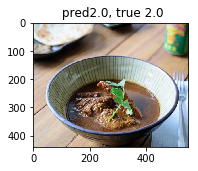

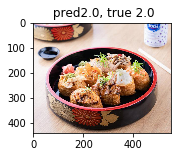

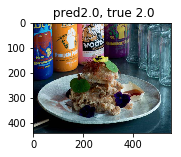

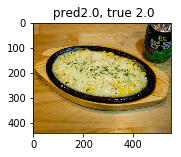

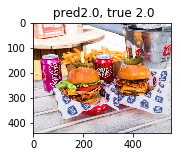

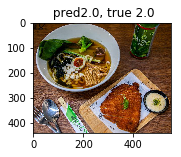

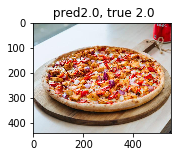

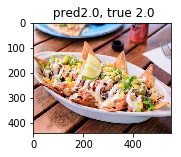

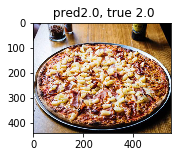

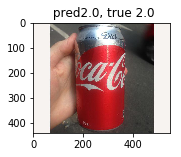

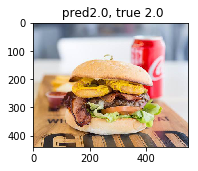

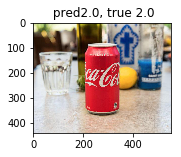

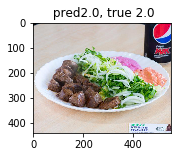

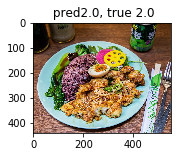

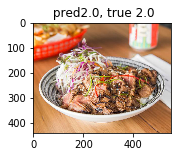

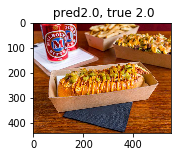

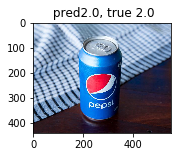

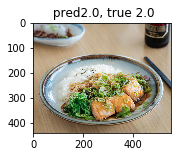

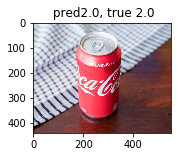

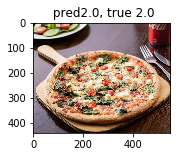

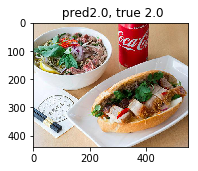

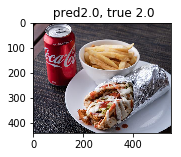

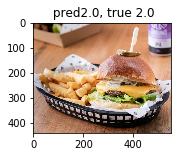

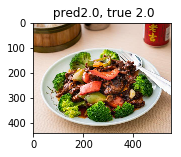

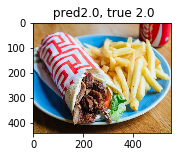

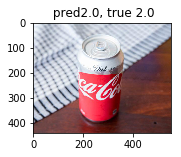

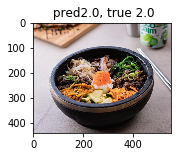

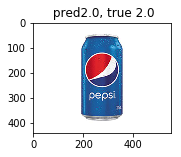

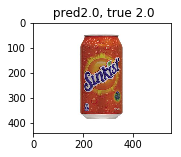

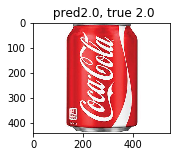

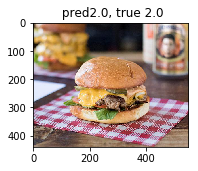

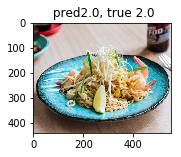

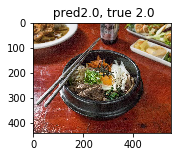

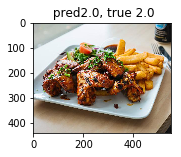

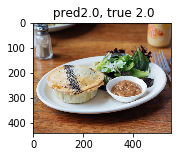

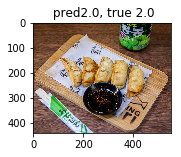

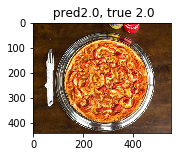

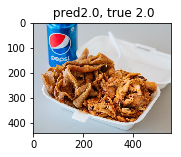

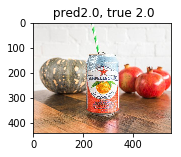

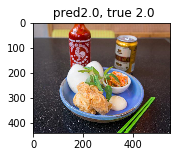

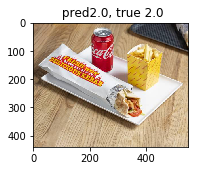

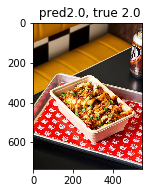

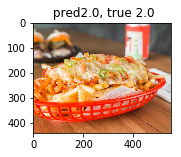

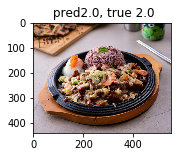

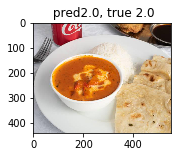

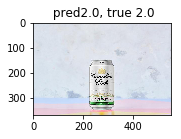

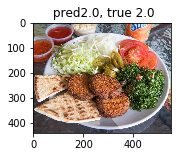

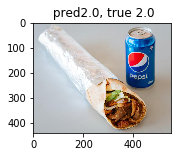

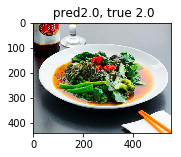

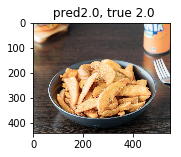

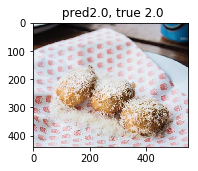

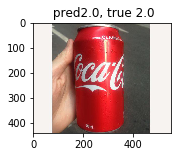

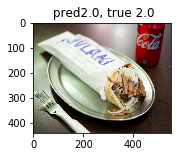

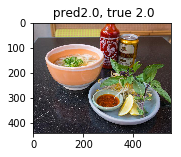

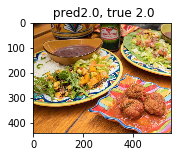

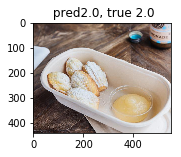

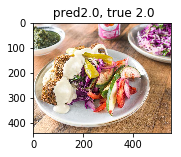

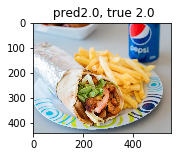

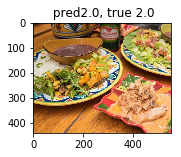

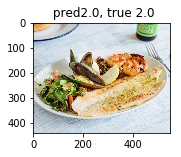

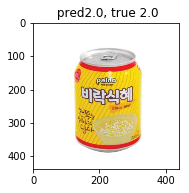

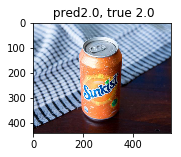

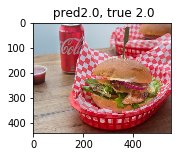

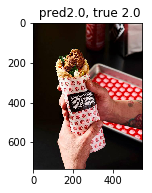

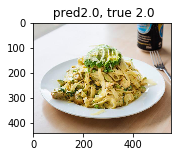

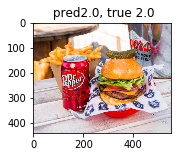

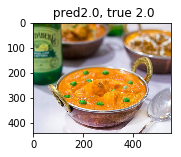

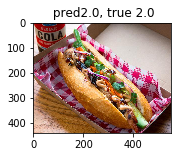

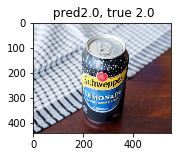

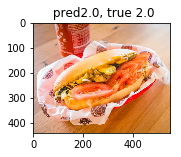

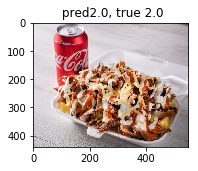

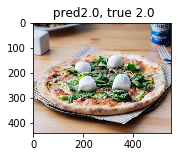

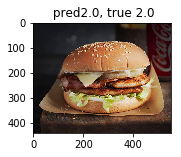

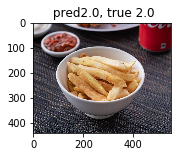

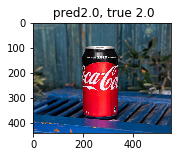

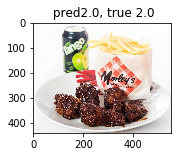

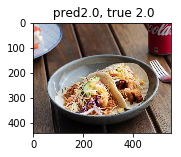

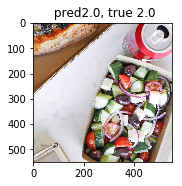

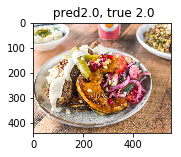

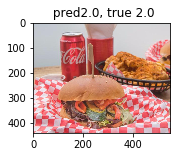

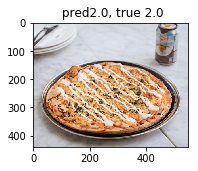

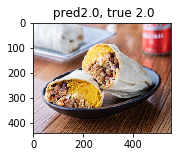

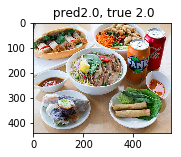

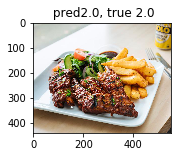

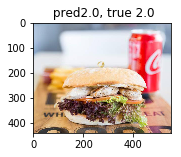

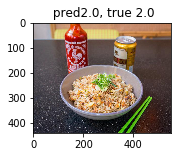

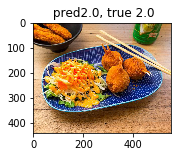

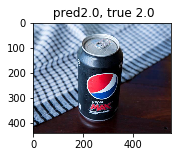

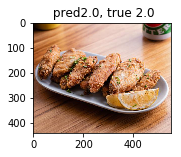

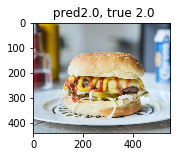

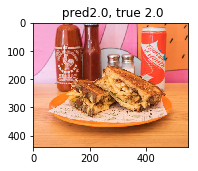

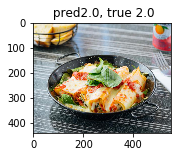

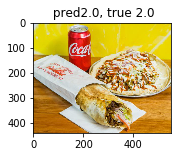

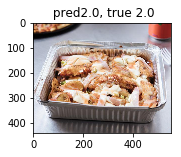

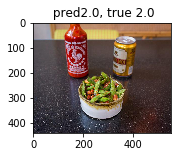

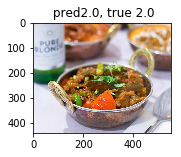

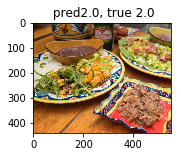

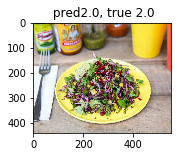

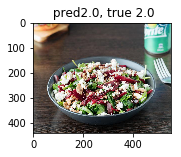

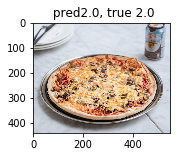

In [12]:
def plot_image(df):
    for i, name in enumerate(df['name'][:100]):
        y_true = np.array(df['true_class']) 
        y_pred = np.array(df['pred_class'])
        fig = plt.figure(figsize=(24, 24))
        plt.subplot(10,10,i+1)
        img_path='/home/ubuntu/cocacola_201904/coke_dataset/models/research/object_detection/ubereats_image/food_image/ubereats/'
        img=img_path+str(name)   
        img_file= plt.imread(img)
        plt.imshow(img_file, 
                   cmap='terrain', 
                   interpolation= 'none')  

        plt.title(" pred{}, true {}".format( y_pred[i], y_true[i]))  
        plt.tight_layout()    
    
plot_image(tp_a_x) 

In [15]:
def bottle_tp():
    output=list()
    for i,df in enumerate([bottle_can_x,bottle_can_z,bottle_can_y,bottle_can_a,bottle_can_fn,bottle_can_fn2]):
        table=df[df['true_class']==1]
        output.append(table[(table['true_class']==1) &(table['pred_class']==1)]) 
    return output 
tp_bottle1, tp_bottle2, tp_bottle3, tp_bottle4, tp_bottle5,tp_bottle6= bottle_tp()  

In [16]:
print(tp_bottle1.shape, tp_bottle2.shape, tp_bottle3.shape, tp_bottle4.shape, tp_bottle5.shape,tp_bottle6.shape)  

(125, 6) (122, 6) (109, 6) (124, 6) (251, 6) (271, 6)


In [17]:
def not_bc_tp():
    output=list()
    for i,df in enumerate([bottle_can_x,bottle_can_z,bottle_can_y,bottle_can_a,bottle_can_fn]):
        table=df[df['true_class']==3]
        output.append(table[(table['true_class']==3) &(table['pred_class']==3)]) 
    return output 
tp_notbc1, tp_notbc2, tp_notbc3, tp_notbc4, tp_notbc5= not_bc_tp() 

In [18]:
print(tp_notbc1.shape, tp_notbc2.shape, tp_notbc3.shape, tp_notbc4.shape, tp_notbc5.shape) 

(4120, 6) (4234, 6) (4396, 6) (4386, 6) (4265, 6)


In [20]:
def get_table1():
    table=list() 
    for i, t1 in enumerate([bottle_can_x,bottle_can_z,bottle_can_y,bottle_can_a,bottle_can_fn, bottle_can_fn2]):
        table.append(t1[t1['true_class']==1]) 
    return table 
b_x,b_y,b_z,b_a,b_fn,b_fn2= get_table1()   

[0.37650602409638556, 0.3674698795180723, 0.32831325301204817, 0.37349397590361444, 0.7560240963855421, 0.8162650602409639]


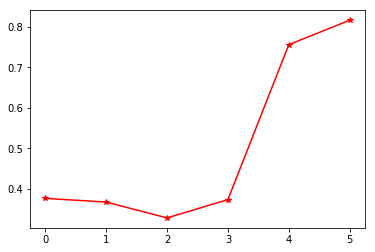

In [21]:
gt_bottle=b_x.shape[0]
bottle=[tp_bottle1.shape[0]/gt_bottle,tp_bottle2.shape[0]/gt_bottle, tp_bottle3.shape[0]/gt_bottle,tp_bottle4.shape[0]/gt_bottle, tp_bottle5.shape[0]/gt_bottle,tp_bottle6.shape[0]/gt_bottle ] 
plt.plot(bottle,color="red", marker='*') 
print(bottle) 
    

In [22]:
def get_table2():
    table=list() 
    for i, t2 in enumerate([bottle_can_x,bottle_can_z,bottle_can_y,bottle_can_a,bottle_can_fn, bottle_can_fn2]):
        table.append(t2[t2['true_class']==2]) 
    return table 
a_x,a_y,a_z,a_a,a_fn,a_fn2= get_table2()   

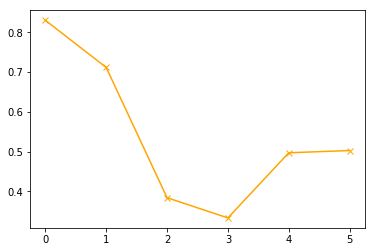

In [24]:
gt_can=a_x.shape[0]
can=[tp1.shape[0]/gt_can,tp2.shape[0]/gt_can, tp3.shape[0]/gt_can, tp4.shape[0]/gt_can, tp5.shape[0]/gt_can,tp6.shape[0]/gt_can] 
plt.plot(can, color='orange', marker='x')    

In [25]:
def get_table3():
    table=list() 
    for i, t3 in enumerate([bottle_can_x,bottle_can_z,bottle_can_y,bottle_can_a,bottle_can_fn, bottle_can_fn2]):
        table.append(t3[t3['true_class']==3]) 
    return table 
c_x,c_y,c_z,c_a,c_fn,c_fn2= get_table3()   

In [27]:
df_x= pd.concat([a_x, b_x, c_x]) 
df_y= pd.concat([a_y ,b_y, c_y]) 
df_z=pd.concat([a_z, b_z, c_z]) 
df_a=pd.concat([a_a,b_a,c_a])
df_fn= pd.concat([a_fn, b_fn, c_fn])
df_fn2=pd.concat([a_fn2, b_fn2, c_fn2])
df_acc_x=df_x.loc[:,['true_class','pred_class','pred_prob']] 
df_acc_y=df_y.loc[:,['true_class','pred_class','pred_prob']] 
df_acc_z=df_z.loc[:,['true_class','pred_class','pred_prob']]  
df_acc_a=df_a.loc[:,['true_class','pred_class','pred_prob']] 
df_acc_fn=df_fn.loc[:,['true_class','pred_class','pred_prob']] 
df_acc_fn2=df_fn2.loc[:,['true_class','pred_class','pred_prob']]
df_acc_a.tail() 

true_class  pred_class  pred_prob
4950         3.0         3.0   0.705231
4951         3.0         3.0   0.987802
4952         3.0         3.0   0.875619
4953         3.0         3.0   0.322657
4954         3.0         3.0   0.997140

In [47]:
#add one more time false negative from currrent best model that trained on last thu 
fn_can= df_x[((df_x['pred_class']==3)|(df_x['pred_class']==1))&(df_x['true_class']==2)] 
fn_bottle= df_x[((df_x['pred_class']==3)|(df_x['pred_class']==2))&(df_x['true_class']==1)] 
fn_can= pd.DataFrame(fn_can.iloc[:,1:])
fn_bottle= pd.DataFrame(fn_bottle.iloc[:,1:])
fn_can.to_csv('fn_can.csv', index=False) 
fn_bottle.to_csv('fn_bottle.csv', index=False) 

In [69]:
%%time 
#download the image for retrain 
import matplotlib.image as mpimg
import numpy as np
import boto3
import io
from boto3 import client 
import cv2 
import scipy.misc 
import imageio 
from tqdm import tqdm 
from tqdm import tqdm_notebook as tqdm 
from time import sleep 

'''configure s3 bucket on aws'''
Bucket= 'dash-external-data'
s3 = boto3.resource('s3') 
bucket = s3.Bucket(Bucket)    
conn = client('s3')    

def download_fn(file):
    for i, row in file.iterrows(): 
        ubereats_img=conn.get_object(Bucket='dash-external-data', Key='food_image/ubereats/'+row['name'])    
        image= ubereats_img['Body'].read() #all the bytes  
        np_arr = np.fromstring(image, np.uint8) #the list of np_arr 
        img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR) 
        RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imageio.imwrite('fn/{}'.format('food_image/ubereats/'+row['name']), RGB_img) 
download_fn(fn_can) 
download_fn(fn_bottle) 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


CPU times: user 7.65 s, sys: 140 ms, total: 7.79 s
Wall time: 31.3 s


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


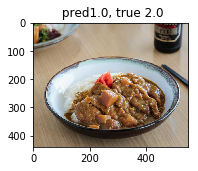

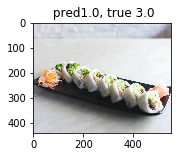

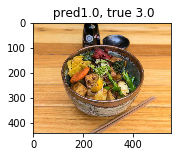

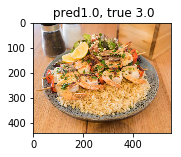

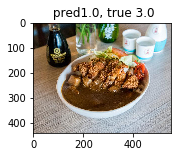

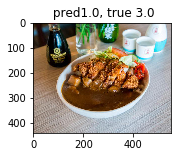

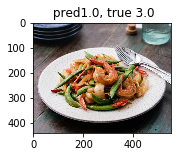

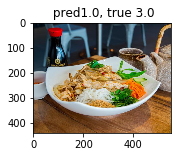

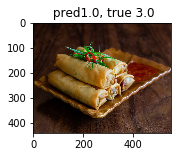

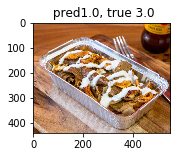

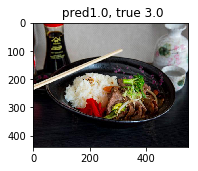

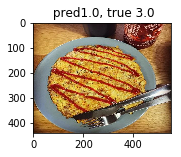

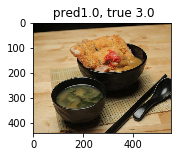

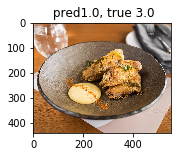

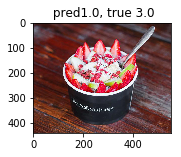

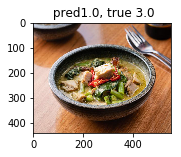

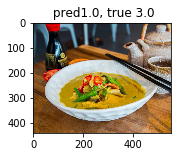

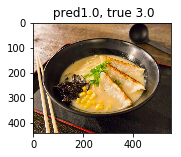

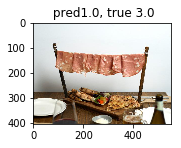

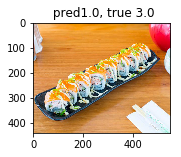

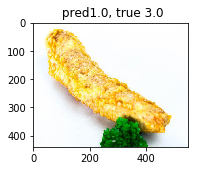

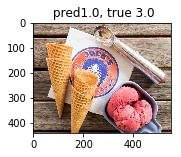

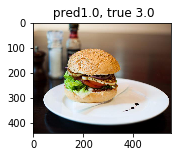

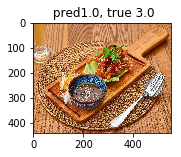

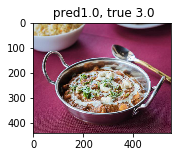

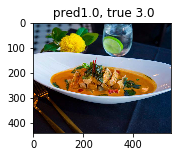

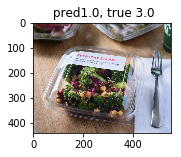

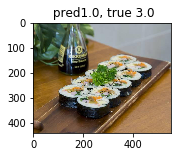

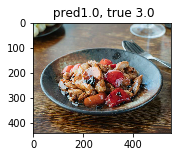

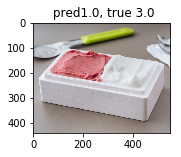

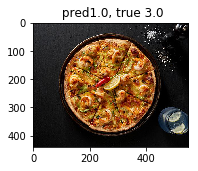

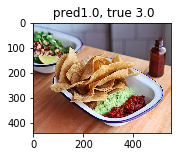

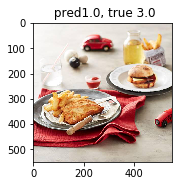

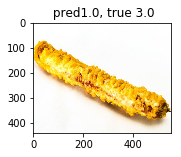

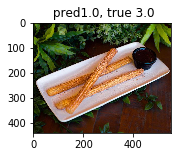

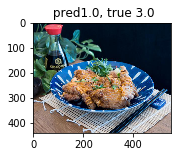

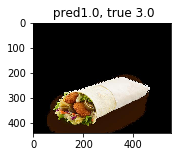

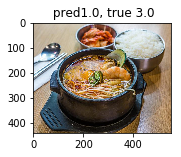

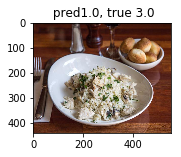

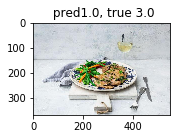

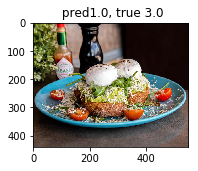

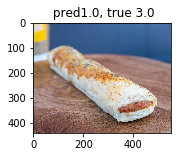

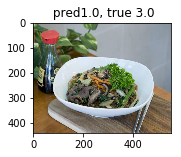

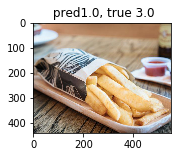

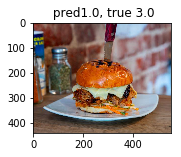

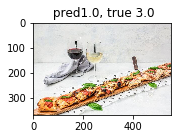

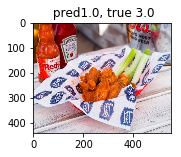

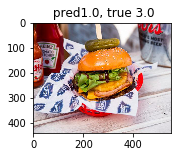

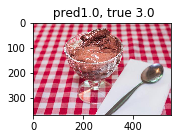

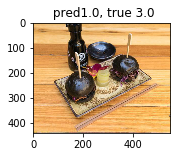

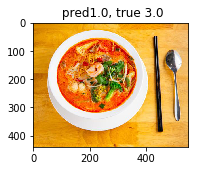

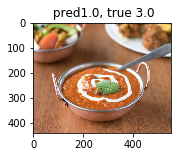

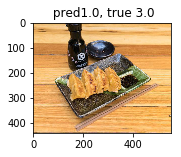

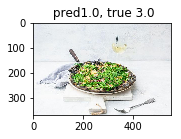

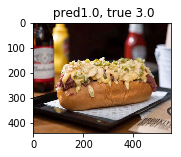

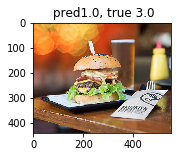

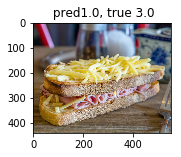

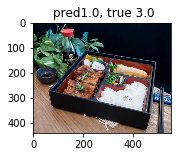

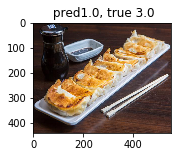

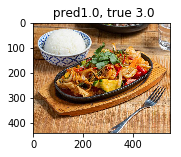

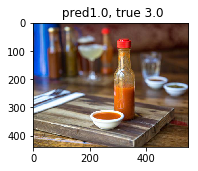

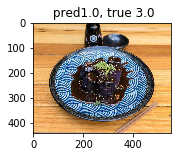

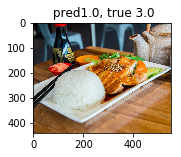

In [16]:
#put the false positive images into the pipeline and retrain the model 
  
fp_bottle= df_x[((df_x['true_class']==3)|(df_x['true_class']==2))&(df_x['pred_class']==1)] 
plot_image(fp_bottle) 

In [20]:
fp_can= df_x[((df_x['true_class']==3)|(df_x['true_class']==1))&(df_x['pred_class']==2)] 
print(fp_can.shape) 
fp_can.tail()

(404, 6)


Label                                  name  \
4857  {"cocacola_tag":"not_bc"}  ae4949751bc95ae9e079fce1c0da8c82.jpg   
4890  {"cocacola_tag":"not_bc"}  7bfbf02e3cf0191af2db8f50d7c42012.jpg   
4896  {"cocacola_tag":"not_bc"}  038cb489c43ffdf9f7901c3ae528ac85.jpg   
4928  {"cocacola_tag":"not_bc"}  6bf63f453686884a534ca69f43f2bf1e.jpg   
4941  {"cocacola_tag":"not_bc"}  78bfb9dfa223da0d57238195fff83e0a.jpg   

      true_class  class_name  pred_prob  pred_class  
4857         3.0         2.0   0.770204         2.0  
4890         3.0         2.0   0.993235         2.0  
4896         3.0         2.0   0.999631         2.0  
4928         3.0         2.0   0.997649         2.0  
4941         3.0         2.0   0.999949         2.0

In [21]:
fp_bottle= df_x[((df_x['true_class']==3)|(df_x['true_class']==2))&(df_x['pred_class']==1)] 
print(fp_bottle.shape) 
fp_bottle.tail()

(63, 6)


Label                                  name  \
4554  {"cocacola_tag":"not_bc"}  da825d9453eb72f185f9bb18cbb3cc09.jpg   
4587  {"cocacola_tag":"not_bc"}  dd6342677f9b1a9cfd6d0c789333cad0.jpg   
4715  {"cocacola_tag":"not_bc"}  12a5178d50eb0bc22c68cba752d3ebbb.jpg   
4803  {"cocacola_tag":"not_bc"}  ad2ccbccb445eb950d4b5362aecbcc92.jpg   
4916  {"cocacola_tag":"not_bc"}  bba19574c48ed9f9a34192f1d6a2ee16.jpg   

      true_class  class_name  pred_prob  pred_class  
4554         3.0         1.0   0.997106         1.0  
4587         3.0         1.0   0.908564         1.0  
4715         3.0         1.0   0.999995         1.0  
4803         3.0         1.0   0.990568         1.0  
4916         3.0         1.0   0.999932         1.0

<h2>Precision & Recall curve </h2> 

In [33]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline    

In [28]:
df_acc_x=df_acc_x[~df_acc_x.isin([np.nan, np.inf, -np.inf]).any(1)] 
df_acc_y=df_acc_y[~df_acc_y.isin([np.nan, np.inf, -np.inf]).any(1)]
df_acc_z=df_acc_z[~df_acc_z.isin([np.nan, np.inf, -np.inf]).any(1)] 
df_acc_a=df_acc_a[~df_acc_a.isin([np.nan, np.inf, -np.inf]).any(1)] 
df_acc_fn=df_acc_fn[~df_acc_fn.isin([np.nan, np.inf, -np.inf]).any(1)] 
df_acc_fn2=df_acc_fn2[~df_acc_fn2.isin([np.nan,np.inf,-np.inf]).any(1)] 

In [29]:
df1=df_acc_x.copy() 
df2=df_acc_x.copy() 
df3=df_acc_y.copy() 
df4=df_acc_y.copy() 
df5=df_acc_z.copy() 
df6=df_acc_z.copy()  
df7=df_acc_a.copy()
df8=df_acc_a.copy() 
df9=df_acc_fn.copy()
df10=df_acc_fn.copy() 
df11=df_acc_fn2.copy() 
df12=df_acc_fn2.copy() 

In [30]:
'''change the multi-class result to the binary, for the ROC, Precision and Recall (PR) curve purpose''' 
def transform2(d1,d2):
    
    d1.loc[d1['true_class']==3,'true_class']=0 
    d1.loc[d1['true_class']==2,'true_class']=0  
    d1.loc[d1['pred_class']==2, 'pred_class']=0
    d1.loc[d1['pred_class']==3, 'pred_class']=0 

    d2.loc[d2['true_class']==3,'true_class']=0 
    d2.loc[d2['true_class']==1,'true_class']=0  
    d2.loc[d2['pred_class']==1, 'pred_class']=0
    d2.loc[d2['pred_class']==3, 'pred_class']=0  
    d2.loc[d2['pred_class']==2, 'pred_class']=1
    d2.loc[d2['true_class']==2, 'true_class']=1  

transform2(df1, df2) #thu 
transform2(df3, df4) #sat after adding fp for the bottle 
transform2(df5, df6) #fri 
transform2(df7, df8) #latest one after adding fp for can 
transform2(df9, df10) 
transform2(df11, df12) 

In [31]:
def show_plot(file,label, color): 
    probs= file['pred_prob']
    y_scores= np.array(probs)  
    y_true = np.array(file['true_class']) 

    auc = roc_auc_score(y_true,y_scores)   
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    print('AUC: {0:.4f}'.format (auc))    

    plt.plot(fpr, tpr, marker='.', linewidth=1, label=label, color=color) 
    plt.plot([0, 1], [0, 1], color= 'navy', linestyle='--') 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
    plt.xlabel('false positive rate') 
    plt.ylabel('true positive rate') 
    plt.legend(loc=0) 
    plt.title('ROC curve for coke cola detection') 

AUC: 0.7642
AUC: 0.7718
AUC: 0.7977


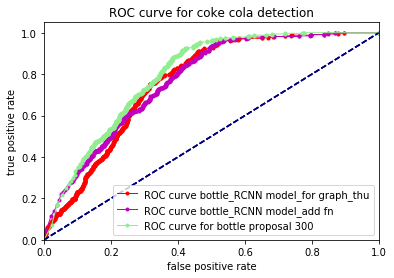

In [37]:
show_plot(df1, label='ROC curve bottle_RCNN model_for graph_thu', color='red') 
# show_plot(df2, label='ROC curve can_RCNN model_graph_thu', color='green') 
# show_plot(df3, label='ROC curve bottle_RCNN model_after add fp', color='blue') 
# show_plot(df4, label='ROC curve can_RCNN model_after add fp', color='c')
# show_plot(df5, label='ROC curve bottle_RCNN model_graph_friday', color='yellow') 
# show_plot(df6, label='ROC curve can_RCNN model_graph_friday', color='orange')  
# show_plot(df7, label='ROC curve bottle_RCNN model_add fp can', color='purple') 
# show_plot(df8, label='ROC curve can_RCNN model_add fp can', color='gray') 
show_plot(df9,label='ROC curve bottle_RCNN model_add fn', color='m')
# show_plot(df10, label='ROC curve can_RCNN model_add fn', color='aqua') 
show_plot(df11, label='ROC curve for bottle proposal 300', color='lightgreen') 
# show_plot(df12, label='ROC curve for can proposal 300', color='gray') 

In [38]:
def show_recall(file, label,color):
    probs = file['pred_prob'] 
    y_scores= np.array(probs)
    y_true = np.array(file['true_class']) 
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores.round())
    f1 = f1_score(y_true, y_scores.round()) 
#     auc = auc(recall, precision)
    ap = average_precision_score(y_true, y_scores.round())
    print('f1=%.3f  ap=%.3f' % (f1, ap))
    plt.plot([0, 1], [0.1, 0.1], linestyle='--')
    plt.plot(recall, precision, marker='.',color=color, label=label) 
    plt.legend(loc=0)  
    plt.title('Precision for coke cola bottle and can detection') 

f1=0.192  ap=0.105
f1=0.108  ap=0.057
f1=0.195  ap=0.107
f1=0.109  ap=0.057
f1=0.209  ap=0.116
f1=0.119  ap=0.063


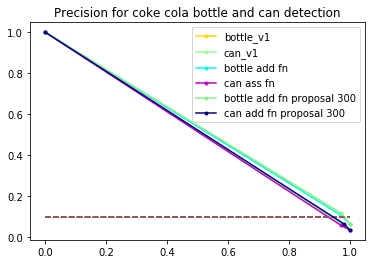

In [40]:
show_recall(df1, color='gold', label='bottle_v1')  
show_recall(df2, color='palegreen', label='can_v1')
# show_recall(df3, color='deepskyblue', label='bottle_add fp')  
# show_recall(df4, color='navy', label='can_add fp')
# show_recall(df5, color='orange', label='bottle_v2')  
# show_recall(df6, color='lawngreen', label='can_v2')
# show_recall(df7, color='blue', label='bottle_add fp v2')  
# show_recall(df8, color='maroon', label='can_add fp v2')  
show_recall(df9, color='aqua', label='bottle add fn') 
show_recall(df10, color='m', label='can ass fn') 
show_recall(df11, color='lightgreen', label='bottle add fn proposal 300') 
show_recall(df12, color='navy', label='can add fn proposal 300') 